In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/'My Drive'/'Data mining'/emnist/

/content/drive/My Drive/Data mining/emnist


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

Using TensorFlow backend.


In [4]:
#!unzip data/7160_10705_compressed_emnist-byclass-test.csv -d data/

In [5]:
#!unzip data/7160_10705_compressed_emnist-byclass-train.csv -d data/

## Reading data

In [6]:
TRAIN_DATA='data/emnist-byclass-train.csv'
TEST_DATA='data/emnist-byclass-test.csv'

In [7]:
df=pd.read_csv(TRAIN_DATA, header=None)
df2=pd.read_csv(TEST_DATA, header=None)
df=pd.concat([df, df2])
df=df.reset_index(drop=True)
del df2
print(df.shape)
df.sample(10)

(814255, 785)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
780121,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
252671,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
625981,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,...,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
661319,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
161966,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
328804,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
783652,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
321886,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
308467,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
126758,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
print(sorted(df[0].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [9]:
def idx2ascii(idx):
    if idx<=9:
        return chr(48+idx)
    elif idx<=35:
        return chr(55+idx)
    else:
        return chr(61+idx)
df[0]= df[0].apply(idx2ascii)

In [10]:
df[0].value_counts()

1    44704
7    41893
3    41112
0    40363
2    40072
     ...  
k     2957
K     2850
p     2816
y     2746
j     2213
Name: 0, Length: 62, dtype: int64

In [11]:
# keep only samples belong to class 0-9, A-Z
import string
keep_list=list(string.digits+ string.ascii_uppercase)
print(keep_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [12]:
df=df[df[0].isin(keep_list)]
print(df.shape)
df.sample(10)

(623257, 785)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
202780,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234178,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31869,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
630392,U,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
165123,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
247825,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
767288,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
330788,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
718957,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
groups=df.groupby(0)
del df
freq= groups[1].count()
print(freq)
min_samples_per_class=freq.min()
print('Min samples per class:',min_samples_per_class)

0
0    40363
1    44704
2    40072
3    41112
4    39154
5    36606
6    39937
7    41893
8    39579
9    39533
A     7469
B     4526
C    11833
D     5341
E     5785
F    10622
G     2964
H     3673
I    13994
J     4388
K     2850
L     5886
M    10487
N     9588
O    29139
P     9744
Q     3018
R     5882
S    24272
T    11396
U    14604
V     5433
W     5501
X     3203
Y     5541
Z     3165
Name: 1, dtype: int64
Min samples per class: 2850


In [14]:
data_list= []
for label, group in groups:
    data=group.to_numpy()
    random_idx=np.random.randint(low=0, high=group.shape[0], size=min_samples_per_class)
    data=data[random_idx, :]
    data_list.append(data)
data=np.concatenate(data_list, axis=0)
np.random.shuffle(data)
print('Data should has length of', 36*min_samples_per_class)
print(data.shape)
print(data[0, :])
del groups

Data should has length of 102600
(102600, 785)
['V' 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 4 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 9 21 32 37 32 21
 8 0 0 0 0 0 0 0 0 0 0 0 0 2 3 4 4 4 4 5 9 21 50 82 114 125 114 81 45 5 0
 0 0 0 0 0 0 0 0 2 18 63 108 127 127 127 127 129 140 172 220 233 245 249
 245 229 190 32 4 0 0 0 0 0 0 0 0 3 31 106 183 216 217 217 217 217 222 233
 250 252 254 254 253 248 214 38 5 0 0 0 0 0 0 0 0 3 32 111 197 247 249 250
 250 250 250 252 254 254 254 254 254 250 221 49 8 0 0 0 0 0 0 0 0 0 7 32
 78 170 203 215 222 236 249 254 255 255 255 254 254 251 227 68 16 1 0 0 0
 0 0 0 0 0 1 7 22 81 114 126 148 192 236 252 255 255 255 254 254 245 208
 44 8 0 0 0 0 0 0 0 0 0 0 0 3 21 32 38 84 160 227 251 254 254 254 254 251
 232 171 22 3 0 0 0 0 0 0 0 0 0 0 0 0 1 9 35 164 221 247 254 254 253 247
 220 202 154 78 3 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 90 219 246 253 2

In [15]:
X=data[:, 1:]
Y=data[:, :1]
del data

Convert label to one-hot encode

In [16]:
onehot_encoder=OneHotEncoder(sparse=False)
Y=onehot_encoder.fit_transform(Y)
print(Y.shape)

(102600, 36)


In [17]:
onehot_encoder.categories_

[array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype=object)]

## Train-Validation-Test set split
60% for train set, 20% for validation set and 20% for test set

In [18]:
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test= train_test_split(x_test, y_test, test_size=0.5, random_state=42 )
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(61560, 784) (61560, 36)
(20520, 784) (20520, 36)
(20520, 784) (20520, 36)


(102600, 784) (102600, 36)
(61560, 28, 28, 1)


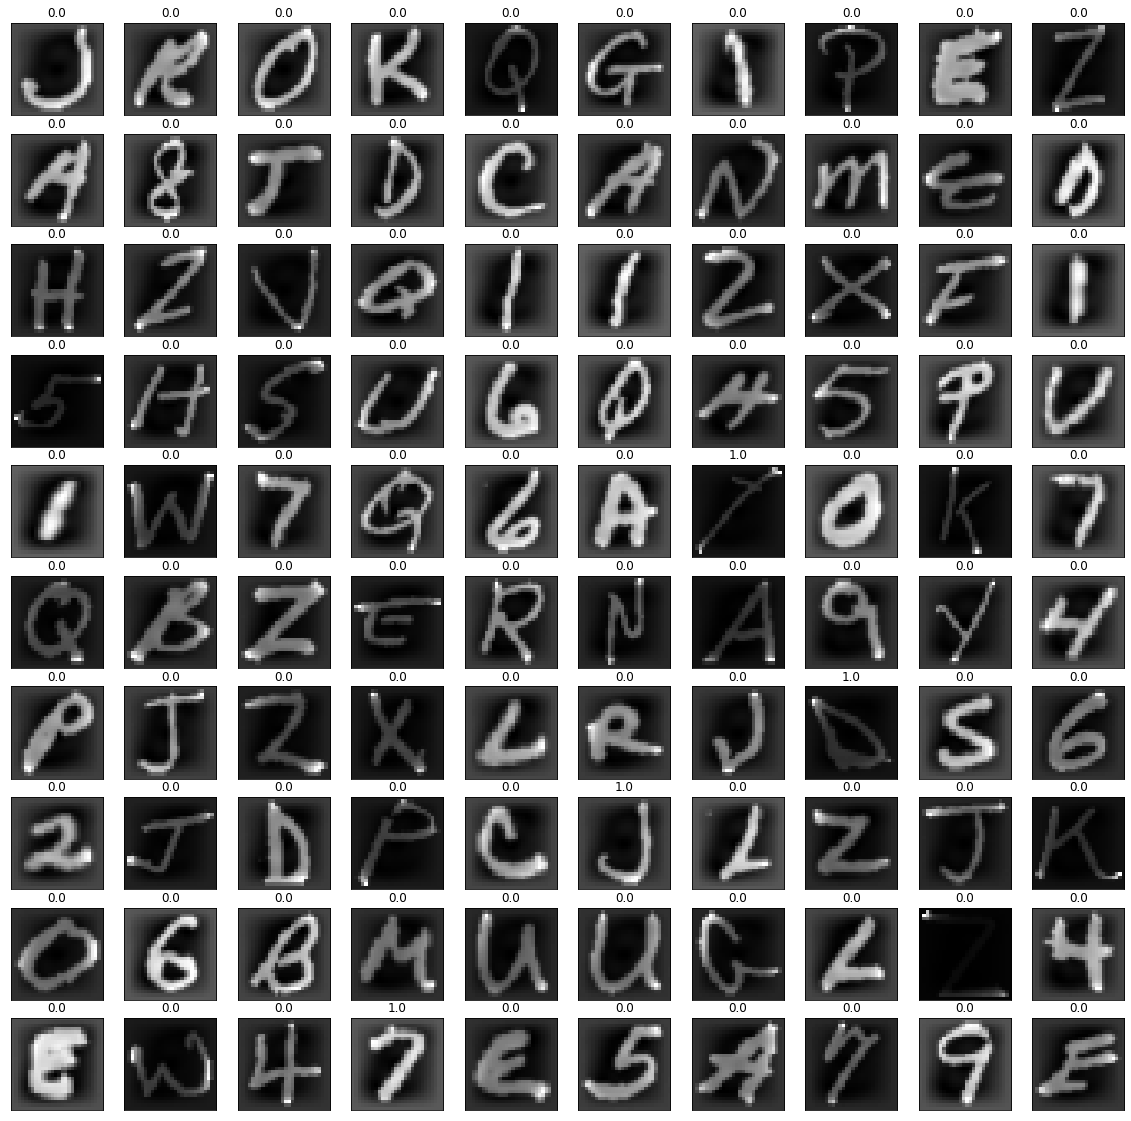

In [19]:
print(X.shape, Y.shape)
standard_scaler=StandardScaler()
x_train=standard_scaler.fit_transform(x_train)
x_val=standard_scaler.transform(x_val)
x_test=standard_scaler.transform(x_test)
x_train = x_train.reshape((-1, 28, 28, 1)).astype(np.float32)
x_val = x_val.reshape((-1, 28, 28, 1)).astype(np.float32)
x_test = x_test.reshape((-1, 28, 28, 1)).astype(np.float32)

print(x_train.shape)
plt.subplots(5,5,figsize=(20,20))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(x_train[i].reshape((28,28)).T,cmap='gray')
  plt.title(Y[i,0])
  plt.xticks([])
  plt.yticks([])

## Image real-time preprocessing and augmentation

(128, 28, 28, 1) (128, 36)


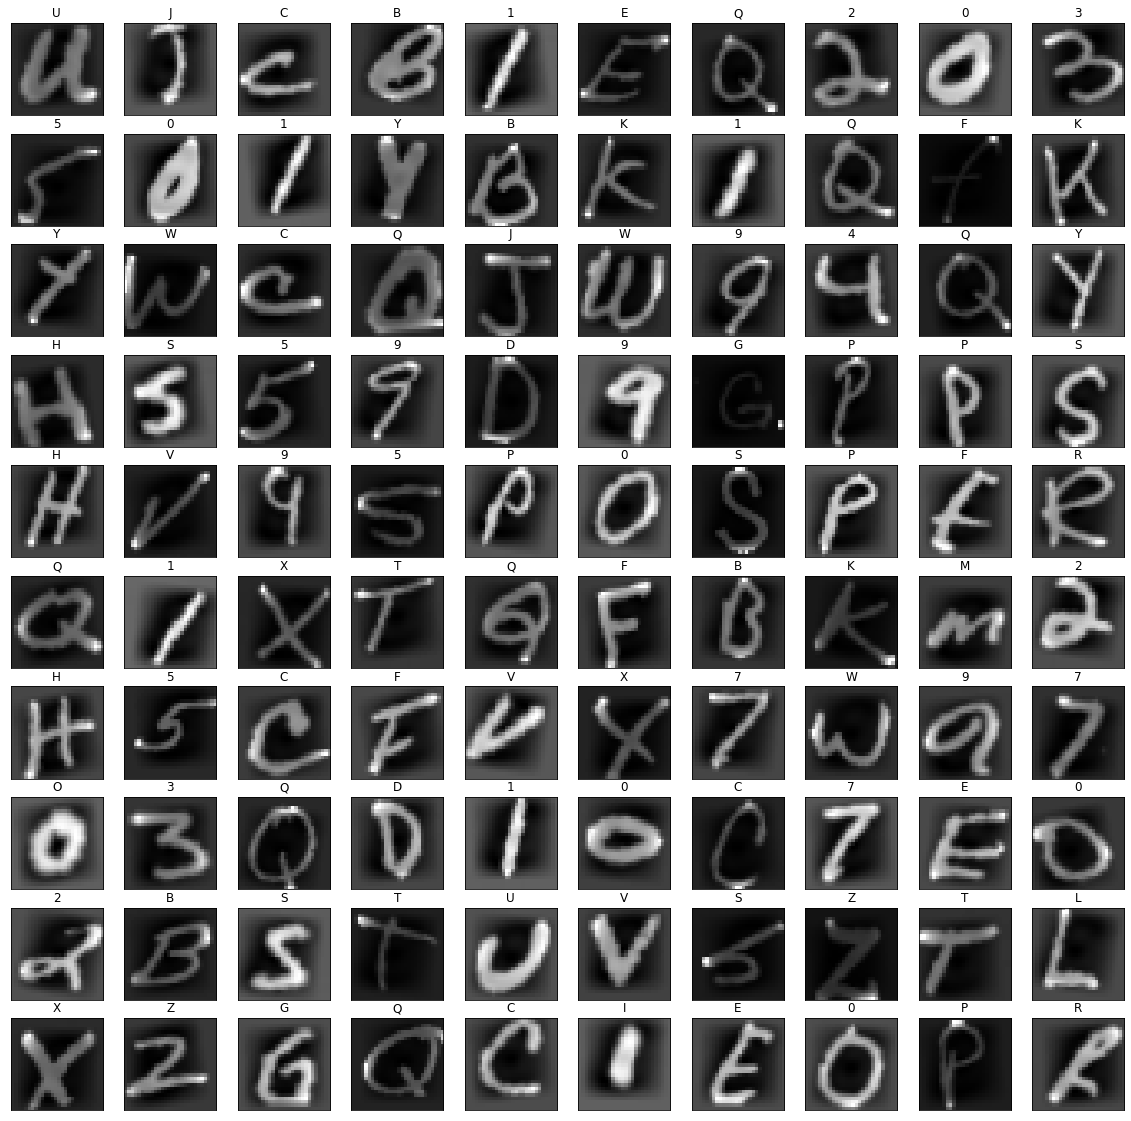

In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(width_shift_range=3, height_shift_range=3, rotation_range=10)

test_generator=datagen.flow(x_train, y_train, batch_size=128, shuffle=True)
test_aug_x, test_aug_y=next(test_generator)
print(test_aug_x.shape, test_aug_y.shape)
test_aug_y_real = onehot_encoder.inverse_transform(test_aug_y)
plt.subplots(5,5,figsize=(20,20))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_aug_x[i].reshape(28,28).T,cmap='gray')
  plt.title(test_aug_y_real[i][0])
plt.show()

## Model training and evaluation
**Detail:**
- Keras
- Callback function:   
  -  Model checkpoint to save best model with the highest accuracy on validation set.
  -  Reduce learning rate 10 time when model is not improved after 10 epochs
  - Early stopping when model is not improved after 15 epochs
- Multi-classes cross-entropy loss function
- Training on maximum 500 epochs

In [21]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback 
from sklearn.metrics import confusion_matrix
import seaborn as sn
from keras.engine.input_layer import Input
from keras.models import Model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
def plot_learning_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [23]:
def predict(model, x):
    y=model.predict(x)
    for i in range(y.shape[0]):
        label=np.argmax(y[i])
        y[i].fill(0)
        y[i][label]=1
    return onehot_encoder.inverse_transform(y)

In [24]:
y_test_raw=onehot_encoder.inverse_transform(y_test)
y_val_raw=onehot_encoder.inverse_transform(y_val)

In [25]:
def evaluate(model, x_test, y_test, y_test_raw):
    print('Accuracy on test set:', model.evaluate(x_test, y_test))
    print('Normalized confusion matrix:')
    y_test_pred_raw=predict(model, x_test)
    ncm=confusion_matrix(y_test_raw, y_test_pred_raw, labels=keep_list, normalize='true')
    print(ncm)
    df_ncm = pd.DataFrame(ncm, index = keep_list,
                    columns = keep_list)
    plt.figure(figsize = (30,30))
    sn.heatmap(df_ncm, annot=True, fmt='.2f')
    plt.show()

In [26]:
def print_classification_report(model, x_test, y_test, y_test_raw):
    global precisions, recalls, f1s
    y_test_pred_raw=predict(model, x_test)

    cm = confusion_matrix(y_test_raw, y_test_pred_raw, labels= keep_list)
    n_sample=np.sum(cm)
    accs={}
    for i in range(len(keep_list)):
        support=np.sum(cm[i,:])
        tp=cm[i,i]
        fn=support - tp
        fp=np.sum(cm[:, i])-tp
        tn=n_sample-tp-fn-fp
        # tpr=tp/(tp+fn)
        # fpr=fp/(fp+tn)
        # se=tpr
        # sp=1-fpr
        acc=(tp+tn)/n_sample
        accs[keep_list[i]]=acc
    print("ACCURACY:")
    for c in ['0', '1', '5', 'I', 'O', 'S' ]:
        print(f"    {c} : {accs[c]}")

    print('CLASSIFICATION REPORT:')
    print(classification_report(y_test_raw, y_test_pred_raw, target_names=keep_list))
    
    metrics= precision_recall_fscore_support(y_test_raw, y_test_pred_raw, labels= keep_list)
    precisions.append(metrics[0])
    recalls.append(metrics[1])
    f1s.append(metrics[2])

In [27]:
def plot_metric_curve(data, labels, metric):
    data=np.array(data)
    print(data.shape)
    plt.subplots(figsize=(14,8))
    for l in labels:
        idx=keep_list.index(l)
        plt.plot(np.arange(0, data.shape[0] *10, 10), data[:, idx ], marker='o')
    plt.legend(labels, loc='upper left')
    plt.title(f'{metric} through each 10 epochs')
    plt.ylabel(metric)
    plt.xlabel('epochs')
    plt.grid()
    plt.show()

In [28]:
class ClassificationReport(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%10 !=0:
            return
        else:
            print(f"-----End epoch {epoch} of training")
            # evaluate(self.model, x_val, y_val, y_val_raw)
            print_classification_report(self.model, x_val, y_val, y_val_raw)
            


In [29]:
# callback functions on end of each epoch
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,verbose=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True, verbose=1)
classification_report_callback=ClassificationReport()

In [30]:
precisions=[]
recalls=[]
f1s=[]
def train_and_evaluate(model, augmentation=True, class_weight=None):
    global precisions, recalls, f1s
    # model_checkpoint=ModelCheckpoint('checkpoints/cnn3/weights-epoch_{epoch:02d}-loss_{loss:.2f}-acc_{accuracy: .2f}-val_loss_{val_loss:.2f}-val_acc_{val_accuracy:.2f}.hdf5', 
    #                              monitor='val_loss',save_best_only=True, save_weights_only=True)
    model_checkpoint=ModelCheckpoint(f'checkpoints/best_weights_{model.__name__}.hdf5', 
                             monitor='val_loss',save_best_only=True, save_weights_only=True)
    model=model(img_shape=(28,28,1),num_classes=36)
    print(model.summary())
    print('----------------------------------------------')
    print('Training..')
    precisions=[]
    recalls=[]
    f1s=[]
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if augmentation:
        history=model.fit(datagen.flow(x_train, y_train, batch_size=4906, shuffle=True), 
                            validation_data=(x_val, y_val), steps_per_epoch=len(x_train)//4096,
                             epochs=500, callbacks=[model_checkpoint, reduce_lr, early_stop, classification_report_callback], class_weight=class_weight)
    else:
        history=model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size= 4096, shuffle=True,
                             epochs=500, callbacks=[model_checkpoint, reduce_lr, early_stop, classification_report_callback], class_weight=class_weight)
    print('-----------------------------------------------')
    print('Learning curve during training phase:')
    plot_learning_curve(history)
    print('-----------------------------------------------')
    print('Final evaluation')
    evaluate(model, x_test, y_test, y_test_raw)
    plot_metric_curve(recalls, ['0', '1', '5', 'I', 'O', 'S' ], 'Recall')
    plot_metric_curve(precisions, ['0', '1', '5', 'I', 'O', 'S' ], 'Precisions')
    plot_metric_curve(f1s, ['0', '1', '5', 'I', 'O', 'S' ], 'F1-score')

    return model

### MLP

In [31]:
def simple_mlp(img_shape=(28,28,1), num_classes=36, weight_decay=1e-3):
    # Input layer
    input = Input(img_shape)
    x = Flatten()(input)
    x = Dense(units=64, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = Dense(units=64, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    output = Dense(units=num_classes, activation='softmax')(x)
    model = Model(inputs=input, outputs=output)
    return model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 36)                2340      
Total params: 56,740
Trainable params: 56,740
Non-trainable params: 0
_________________________________________________________________
None
----------------------------------------------
Training..
Train on 61560 samples, validate on 20520 samples
Epoch 1/

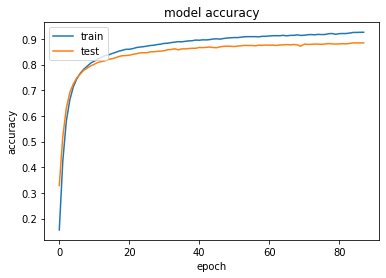

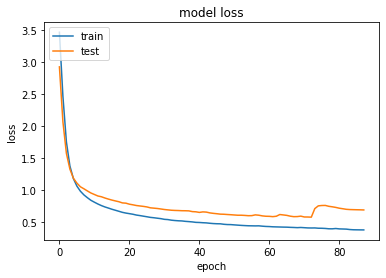

-----------------------------------------------
Final evaluation
20520/20520 [==============================] - 1s 54us/step
Accuracy on test set: [0.601809153164107, 0.8755360841751099]
Normalized confusion matrix:
[[0.78165138 0.         0.00183486 ... 0.         0.         0.        ]
 [0.         0.83423423 0.         ... 0.0018018  0.00540541 0.        ]
 [0.00338409 0.         0.84094755 ... 0.00169205 0.         0.09475465]
 ...
 [0.         0.00340716 0.00170358 ... 0.93015332 0.01022147 0.        ]
 [0.         0.         0.         ... 0.00866551 0.87001733 0.        ]
 [0.         0.         0.03684211 ... 0.         0.         0.91929825]]


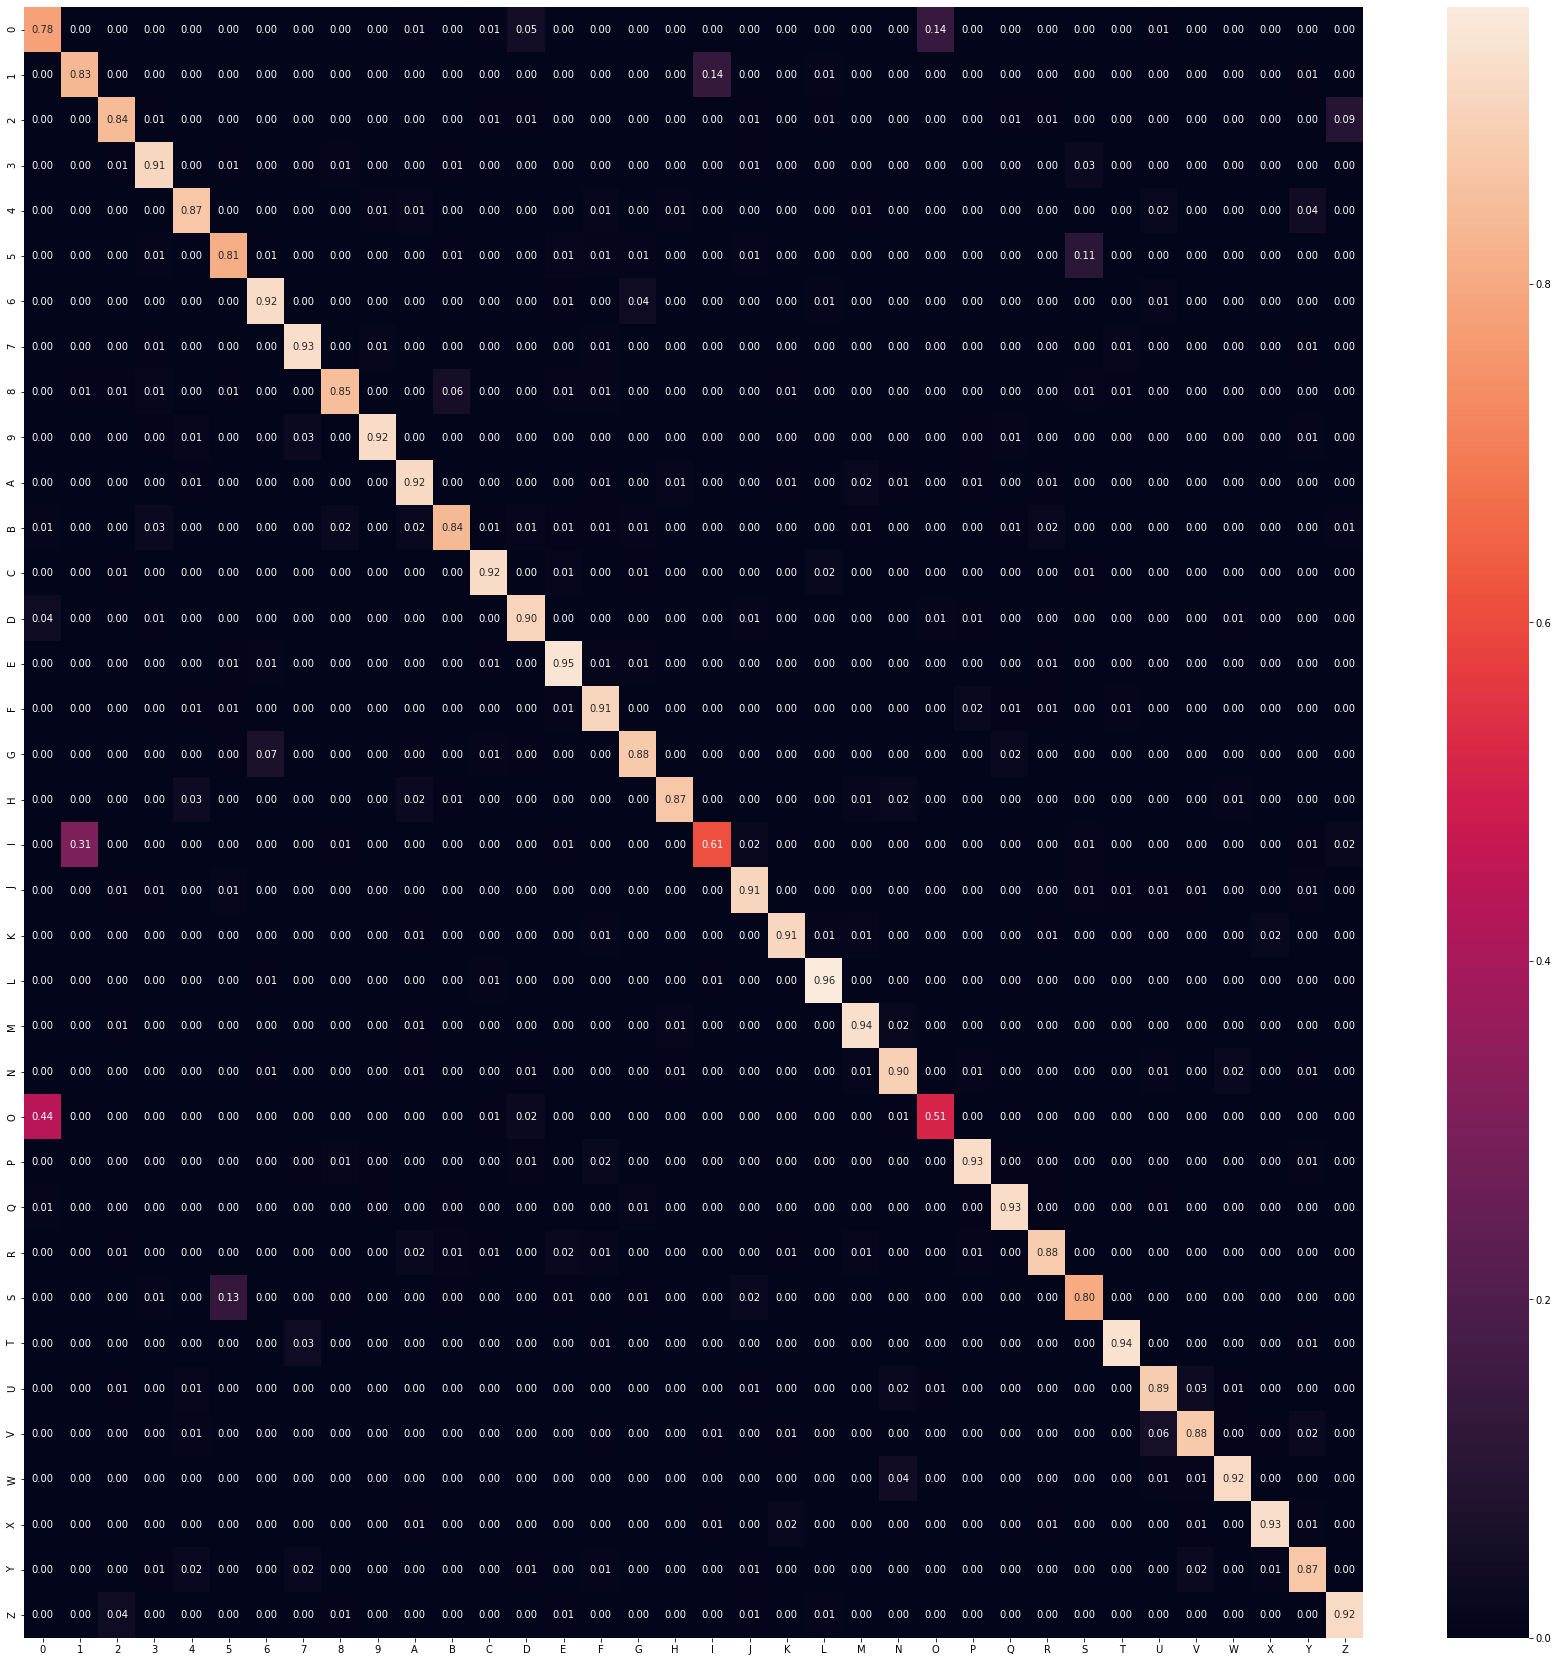

(9, 36)


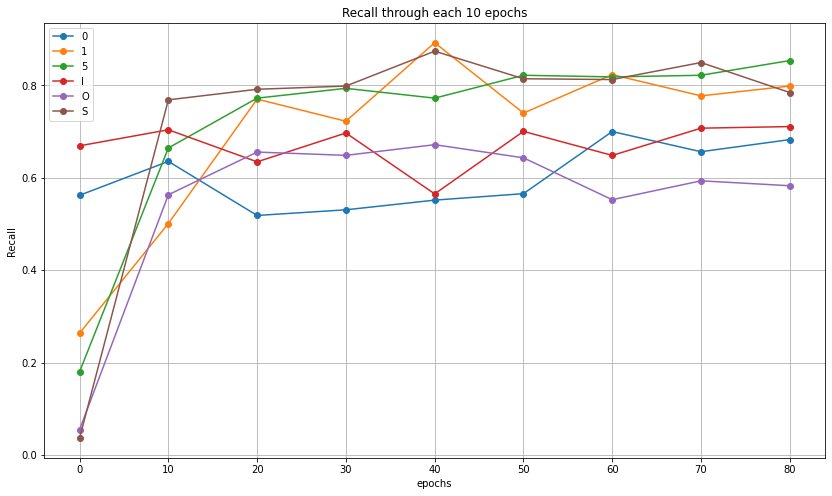

(9, 36)


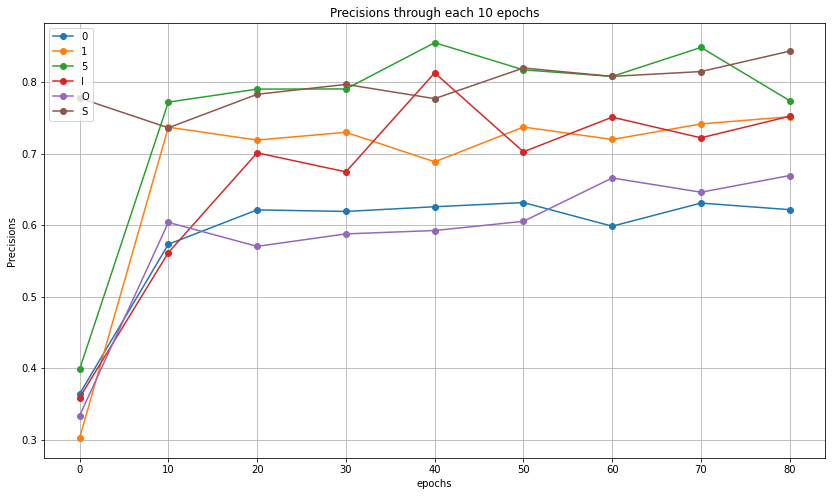

(9, 36)


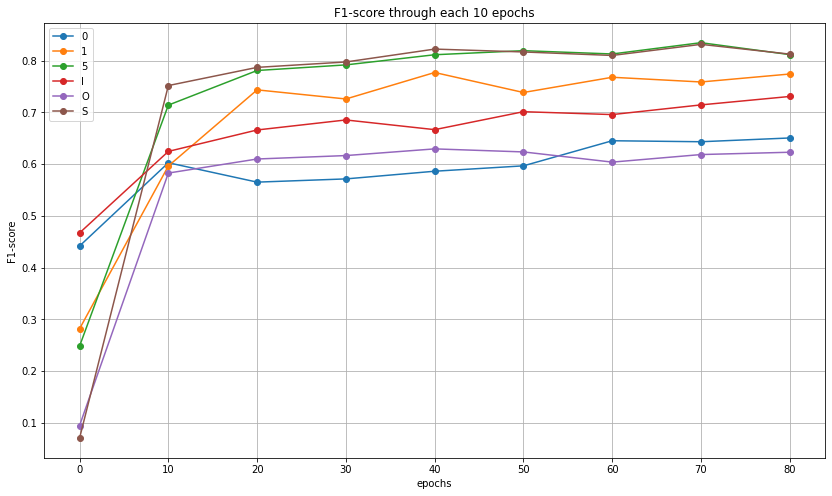

In [32]:
train_and_evaluate(simple_mlp, augmentation=False)

### Lenet

In [33]:
def lenet(img_shape=(28,28,1), num_classes=36, weight_decay=1e-3):
    # Input layer
    input = Input(img_shape)
    
    # Layer 1
    x = Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', kernel_regularizer=l2(weight_decay),
                     activation='relu')(input)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    # Layer 2
    x = Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', kernel_regularizer=l2(weight_decay),
               activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    # Layer 3
    x = Flatten()(x)
    
    x = Dense(units=120, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    
    # Layer 4
    x = Dense(units=84, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    
    # Layer 5
    output = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)
    
    return model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               3084

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.19      0.39      0.25       573
           1       0.00      0.00      0.00       565
           2       0.28      0.38      0.32       544
           3       1.00      0.00      0.00       602
           4       0.19      0.63      0.30       553
           5       0.14      0.00      0.01       566
           6       1.00      0.01      0.01       583
           7       0.72      0.19      0.30       581
           8       0.29      0.23      0.26       569
           9       0.00      0.00      0.00       555
           A       0.41      0.09      0.15       540
           B       0.49      0.08      0.14       560
           C       0.38      0.15      0.22       576
           D       0.43      0.23      0.30       600
           E       0.10      0.04      0.06       612
           F       0.40      0.27      0.32       534
           G       0.65      0.42      0.51       534
           H       0.00    

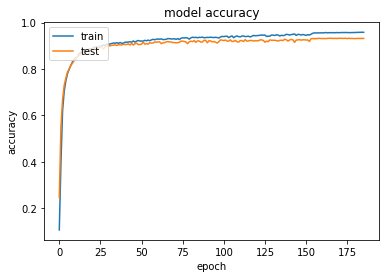

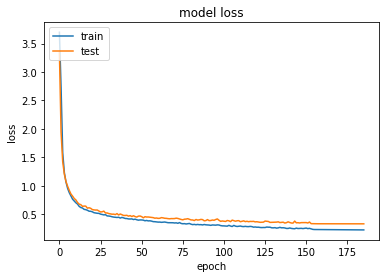

-----------------------------------------------
Final evaluation
20520/20520 [==============================] - 1s 62us/step
Accuracy on test set: [0.4681342608979803, 0.928947389125824]
Normalized confusion matrix:
[[0.72844037 0.         0.         ... 0.         0.         0.        ]
 [0.         0.82882883 0.         ... 0.         0.         0.        ]
 [0.         0.         0.91370558 ... 0.         0.         0.06598985]
 ...
 [0.         0.         0.         ... 0.98977853 0.         0.00170358]
 [0.         0.0017331  0.         ... 0.00519931 0.90987868 0.        ]
 [0.         0.         0.04210526 ... 0.00175439 0.         0.93859649]]


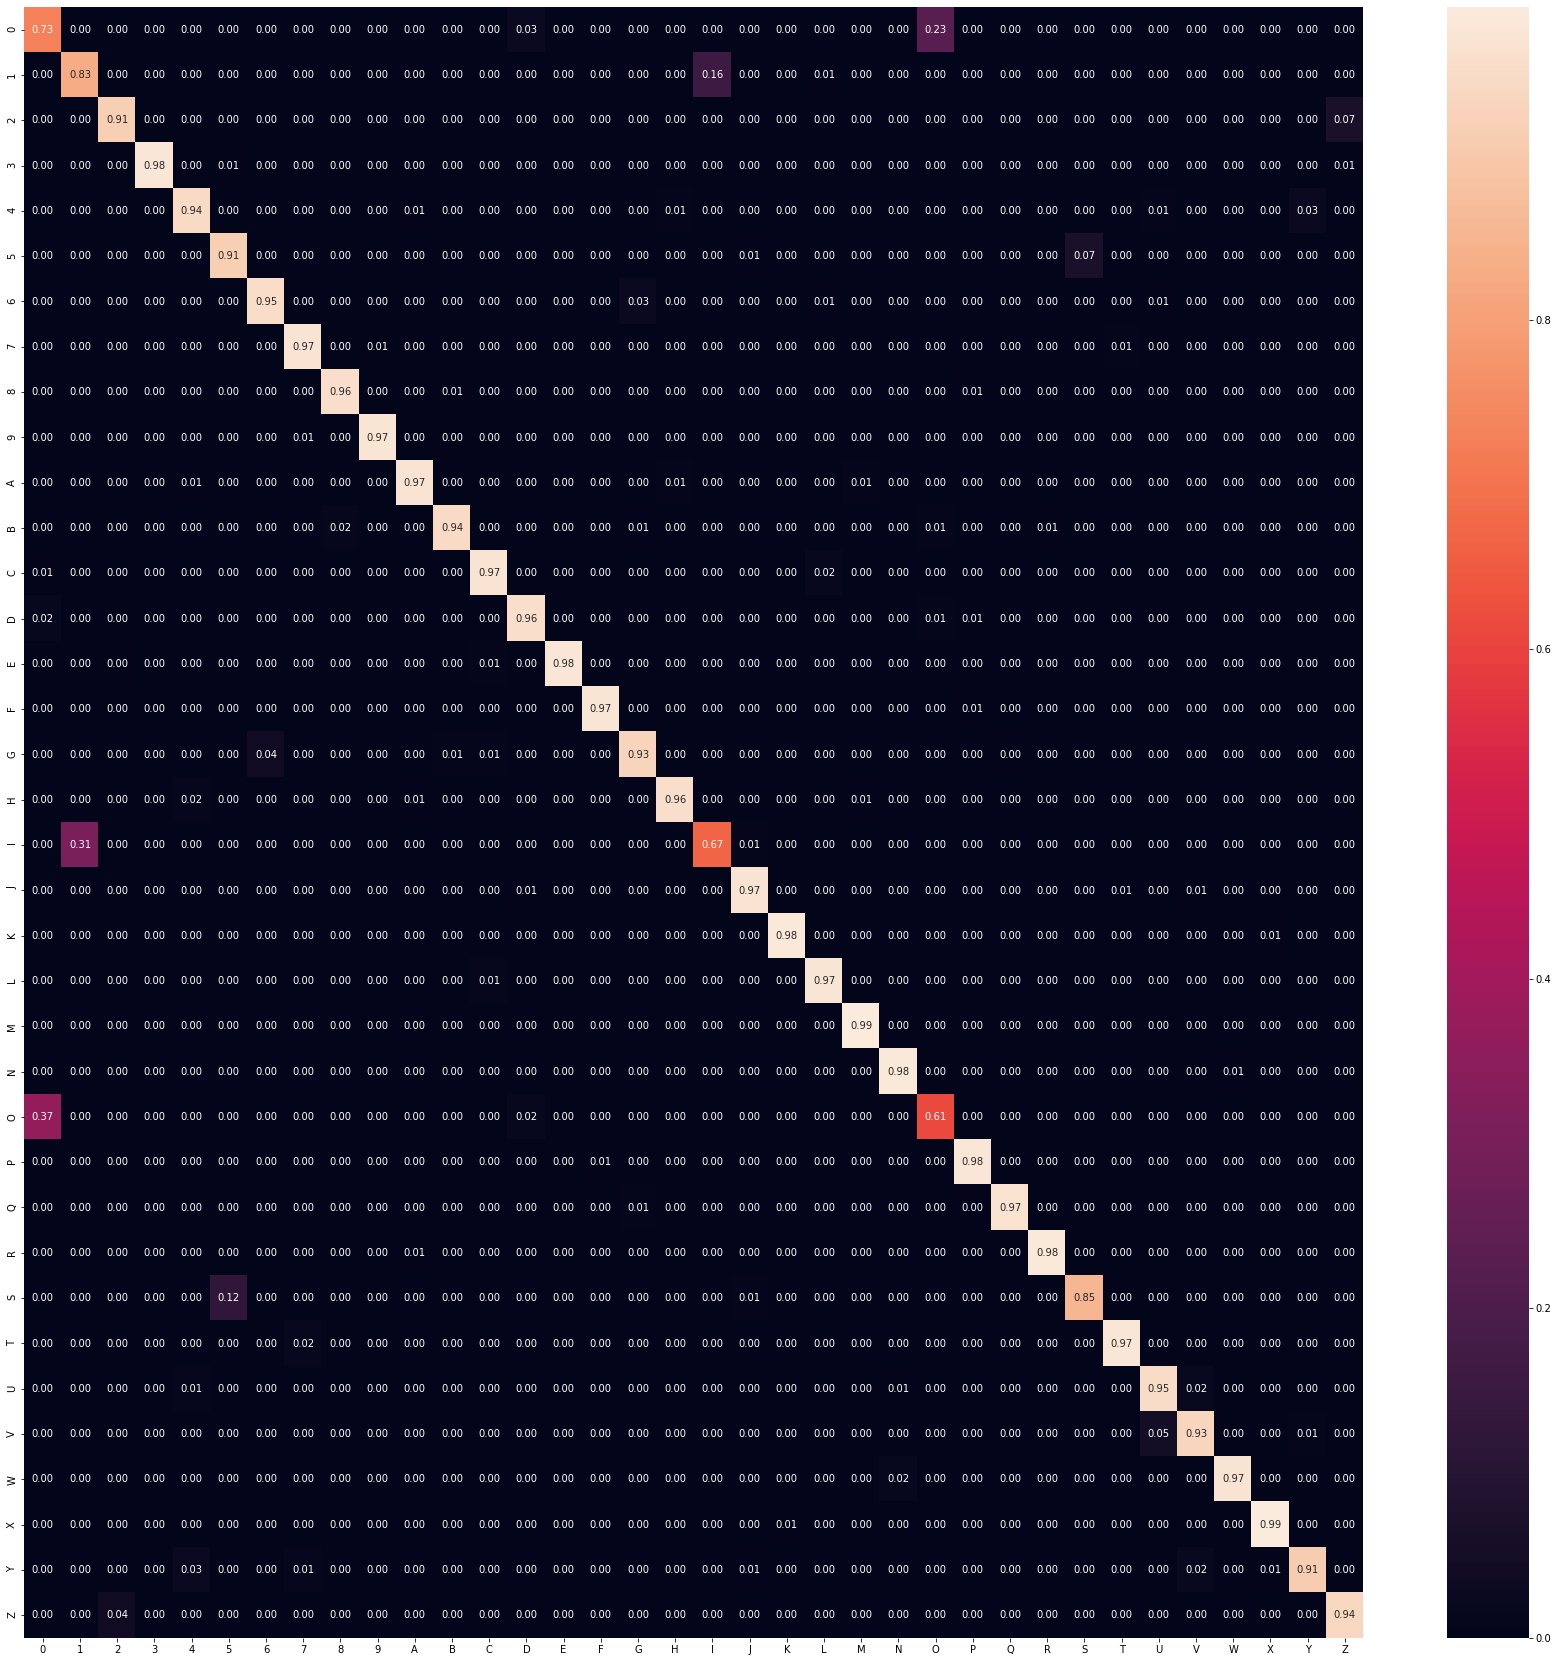

(19, 36)


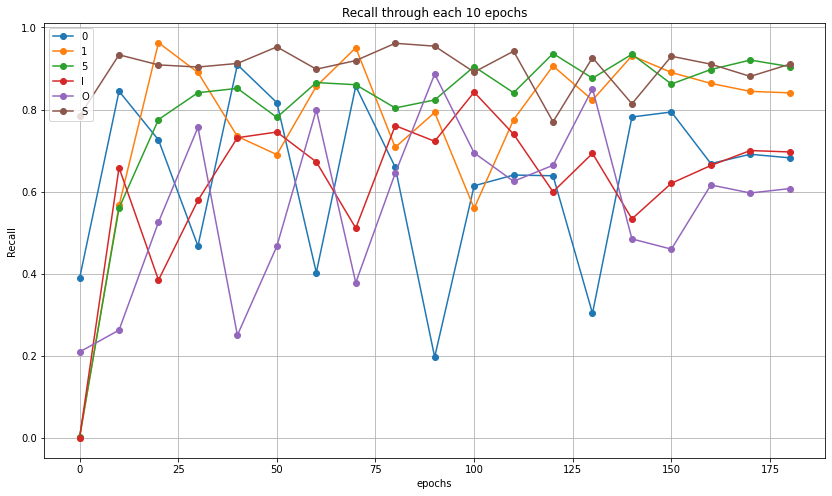

(19, 36)


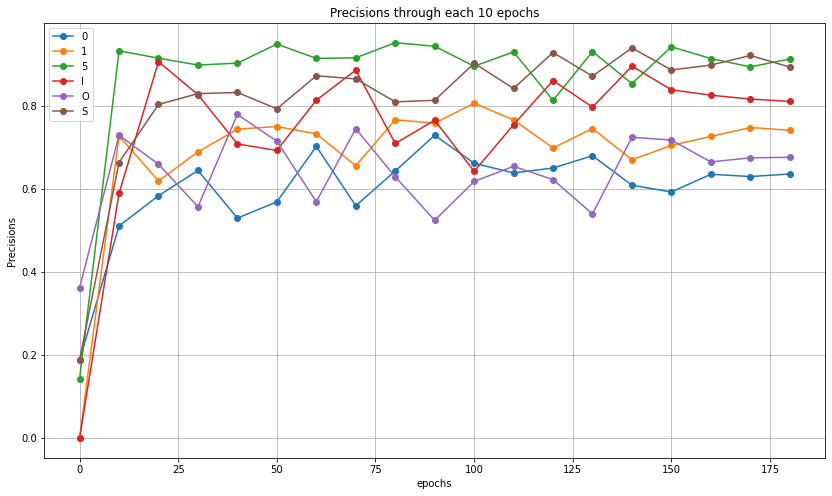

(19, 36)


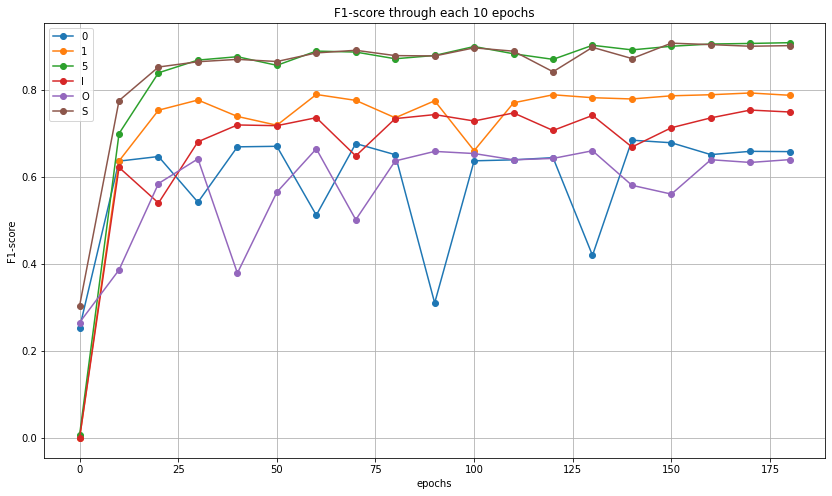

In [34]:
train_and_evaluate(lenet, augmentation=False)

### Custom VGG16

In [35]:
def myvgg(img_shape=(28,28,1), num_classes=36, weight_decay=1e-4):
    # Input layer
    input = Input(img_shape)
    
    # Layer 1
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu', bias_initializer='zeros')(input)
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    # Layer 2
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    
    # Layer 3
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    
    # Layer 4
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    
    # Layer 5
    x = Flatten()(x)
    x = Dense(units=256, activation='relu', kernel_regularizer=l2(weight_decay), bias_initializer='zeros')(x)
    x=Dropout(rate=0.3)(x)
    x = Dense(units=256, activation='relu', kernel_regularizer=l2(weight_decay), bias_initializer='zeros')(x)
    x=Dropout(rate=0.3)(x)
    
    # Output layer
    # Softmax activation
    x = Dense(units=num_classes, bias_initializer='zeros')(x)
    output=Activation('softmax')(x)

    model = Model(inputs=input, outputs=output)
    
    return model

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0   

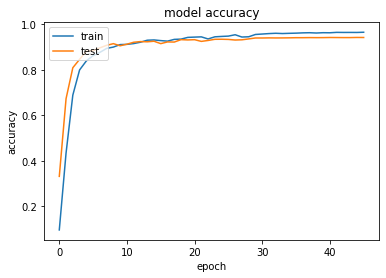

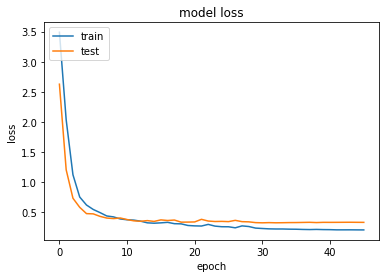

-----------------------------------------------
Final evaluation
20520/20520 [==============================] - 2s 113us/step
Accuracy on test set: [0.35693735045183006, 0.9393274784088135]
Normalized confusion matrix:
[[0.69541284 0.         0.         ... 0.         0.         0.        ]
 [0.         0.85945946 0.         ... 0.         0.         0.        ]
 [0.         0.         0.93062606 ... 0.         0.         0.05752961]
 ...
 [0.         0.         0.         ... 0.99318569 0.00170358 0.        ]
 [0.         0.         0.         ... 0.0034662  0.93414211 0.        ]
 [0.         0.         0.03508772 ... 0.         0.         0.96315789]]


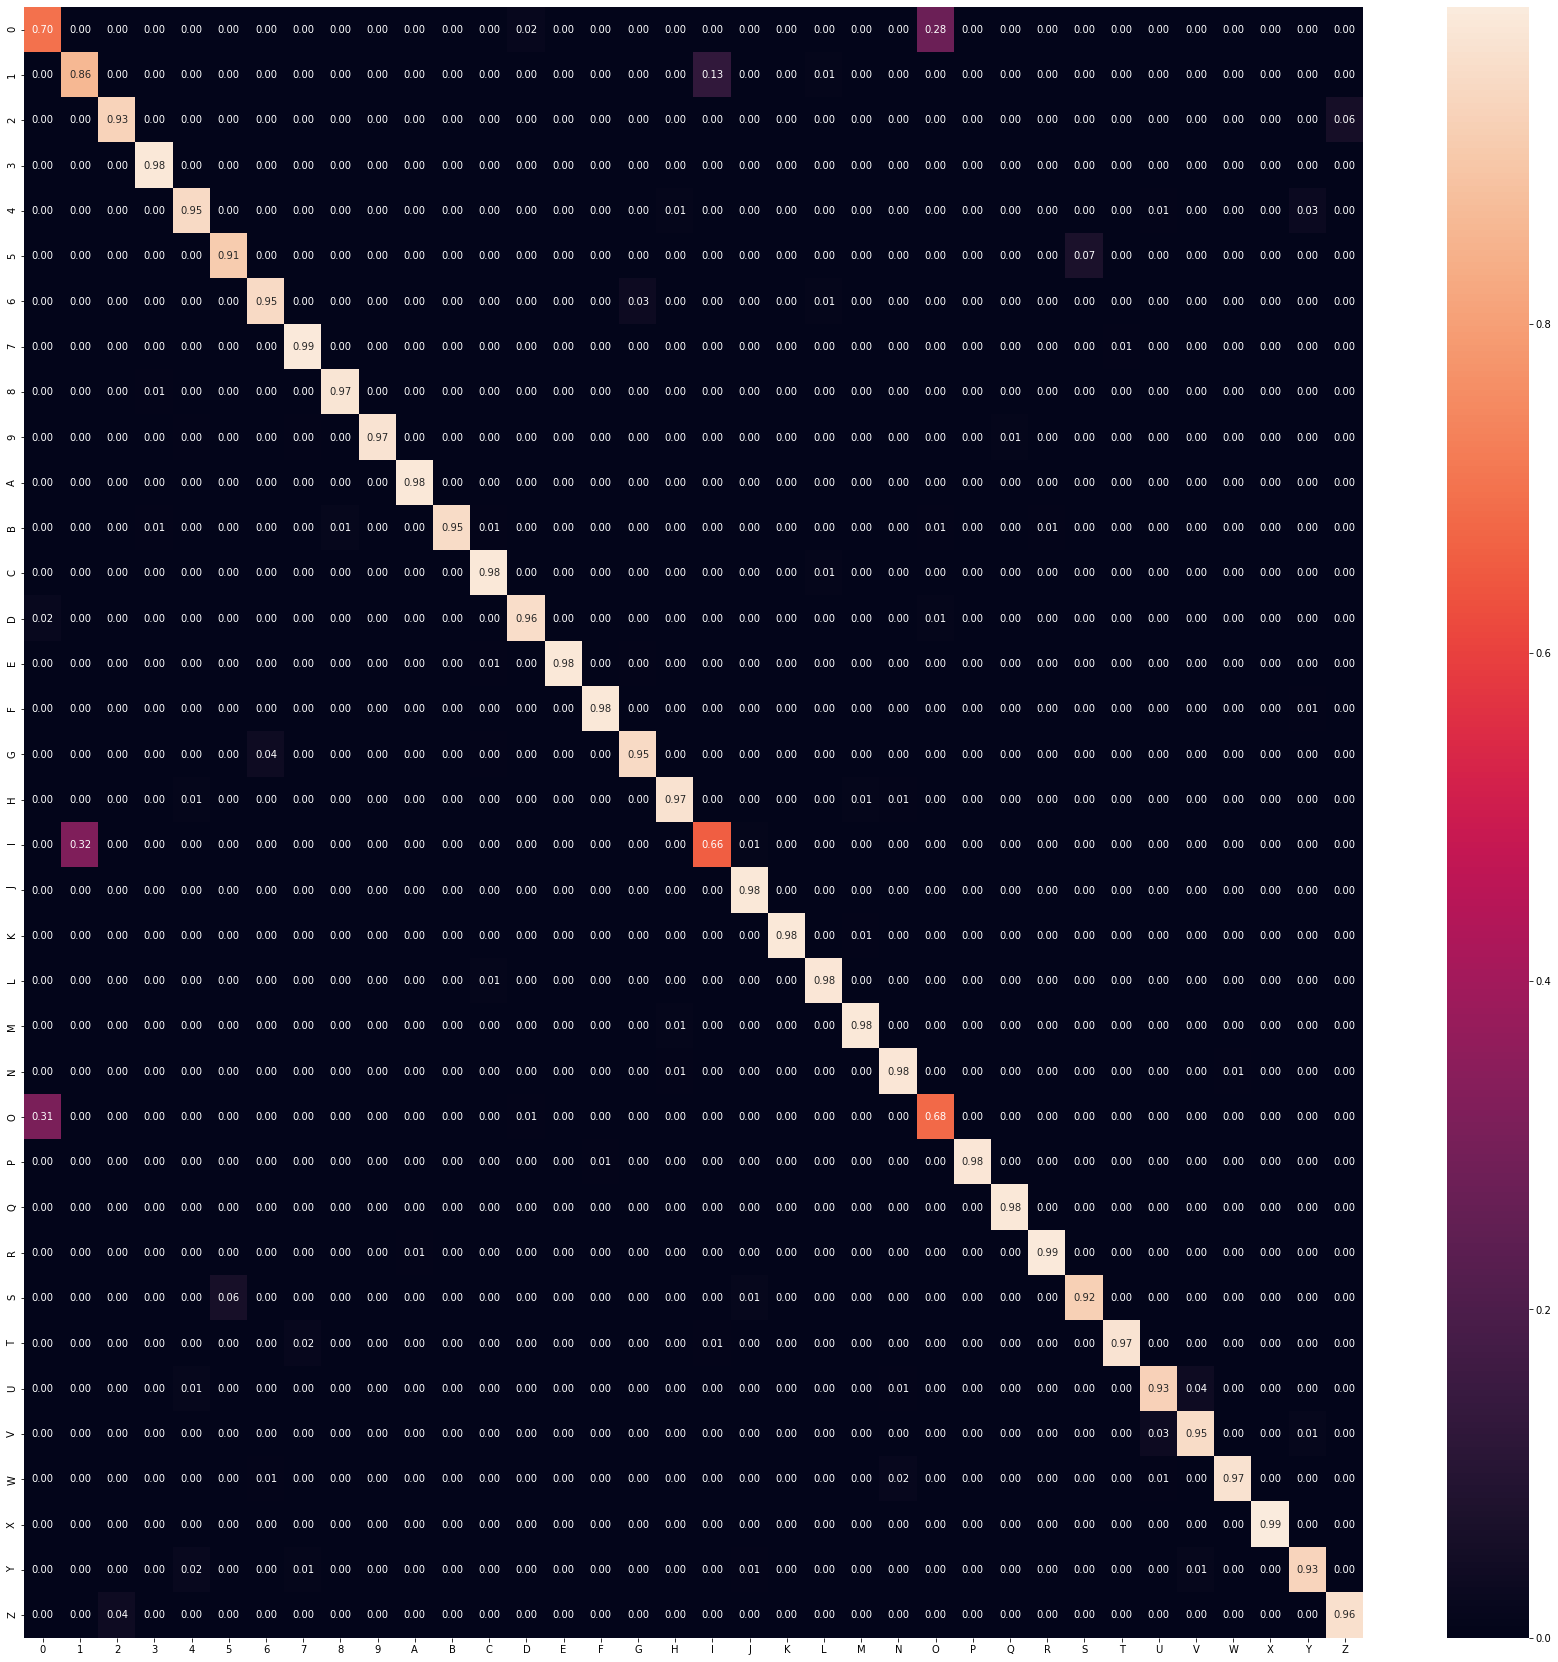

(5, 36)


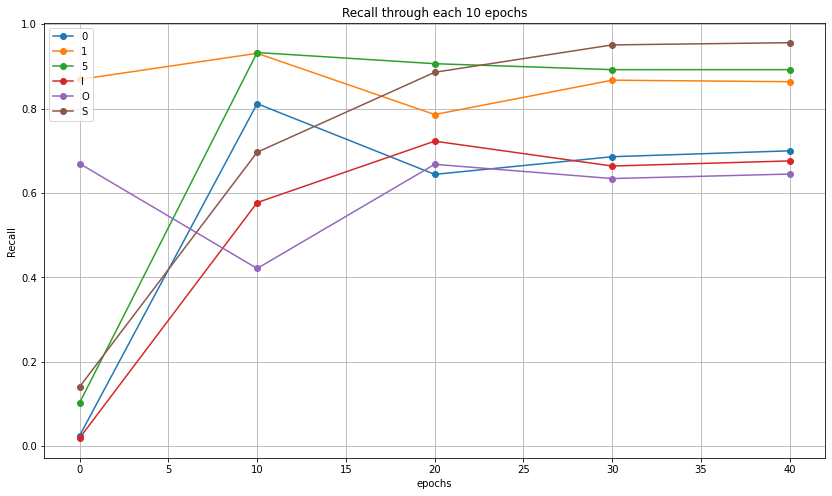

(5, 36)


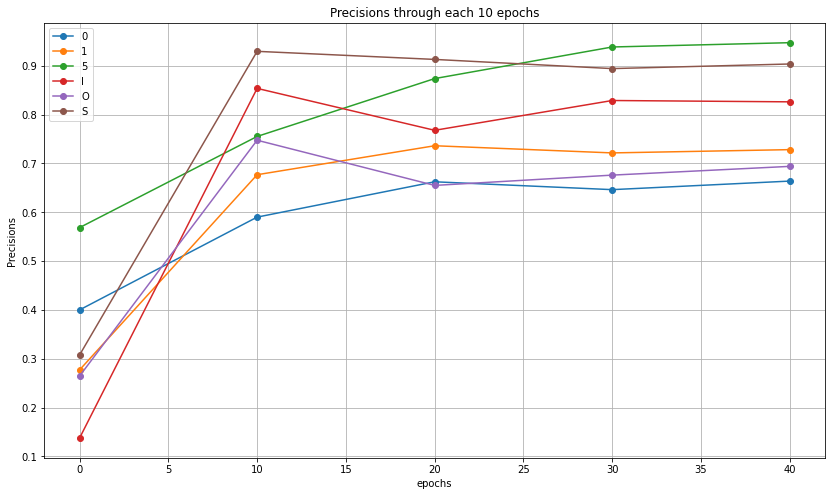

(5, 36)


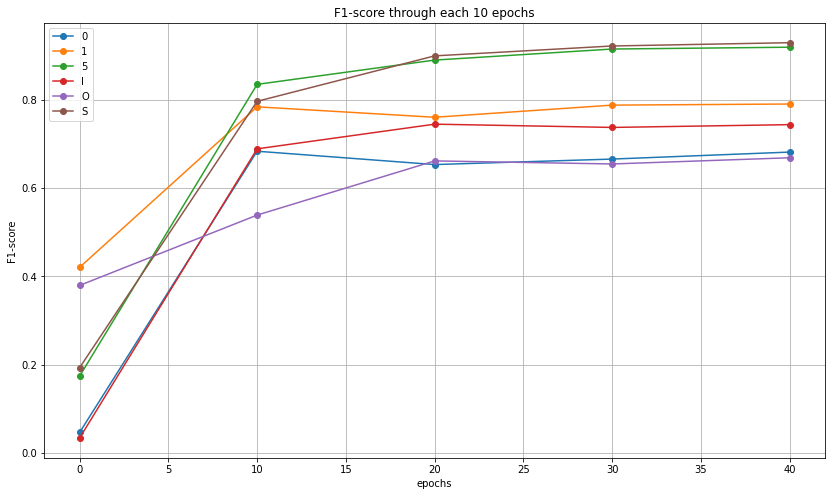

In [36]:
train_and_evaluate(myvgg, augmentation=False)

In [37]:
def myvgg2(img_shape=(28,28,1), num_classes=36, weight_decay=1e-4):
    # Input layer
    input = Input(img_shape)
    
    # Layer 1
    x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu', bias_initializer='zeros')(input)
    x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    # Layer 2
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    
    # Layer 3
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    
    # Layer 4
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    
    # Layer 5
    x = Flatten()(x)
    x = Dense(units=128, activation='relu', kernel_regularizer=l2(weight_decay), bias_initializer='zeros')(x)
    x=Dropout(rate=0.3)(x)
    x = Dense(units=128, activation='relu', kernel_regularizer=l2(weight_decay), bias_initializer='zeros')(x)
    x=Dropout(rate=0.3)(x)
    
    # Output layer
    # Softmax activation
    x = Dense(units=num_classes, bias_initializer='zeros')(x)
    output=Activation('softmax')(x)

    model = Model(inputs=input, outputs=output)
    
    return model

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       573
           1       0.06      0.01      0.01       565
           2       0.00      0.00      0.00       544
           3       0.00      0.00      0.00       602
           4       0.19      0.09      0.12       553
           5       0.00      0.00      0.00       566
           6       0.00      0.00      0.00       583
           7       0.46      0.12      0.19       581
           8       0.00      0.00      0.00       569
           9       0.12      0.61      0.20       555
           A       0.40      0.00      0.01       540
           B       0.00      0.00      0.00       560
           C       0.00      0.00      0.00       576
           D       0.12      0.01      0.03       600
           E       0.25      0.00      0.00       612
           F       0.09      0.01      0.03       534
           G       0.28      0.21      0.24       534
           H       0.00    

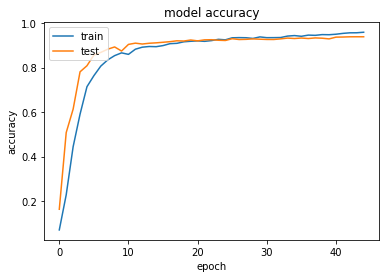

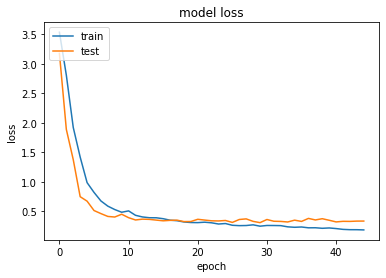

-----------------------------------------------
Final evaluation
20520/20520 [==============================] - 2s 94us/step
Accuracy on test set: [0.36781585567992103, 0.927582859992981]
Normalized confusion matrix:
[[0.7706422  0.         0.         ... 0.         0.         0.        ]
 [0.0018018  0.85585586 0.         ... 0.         0.0018018  0.        ]
 [0.         0.         0.84094755 ... 0.         0.         0.13874788]
 ...
 [0.         0.         0.00170358 ... 0.98637138 0.00340716 0.00170358]
 [0.0017331  0.         0.         ... 0.0034662  0.91854419 0.        ]
 [0.         0.         0.0122807  ... 0.00350877 0.         0.98421053]]


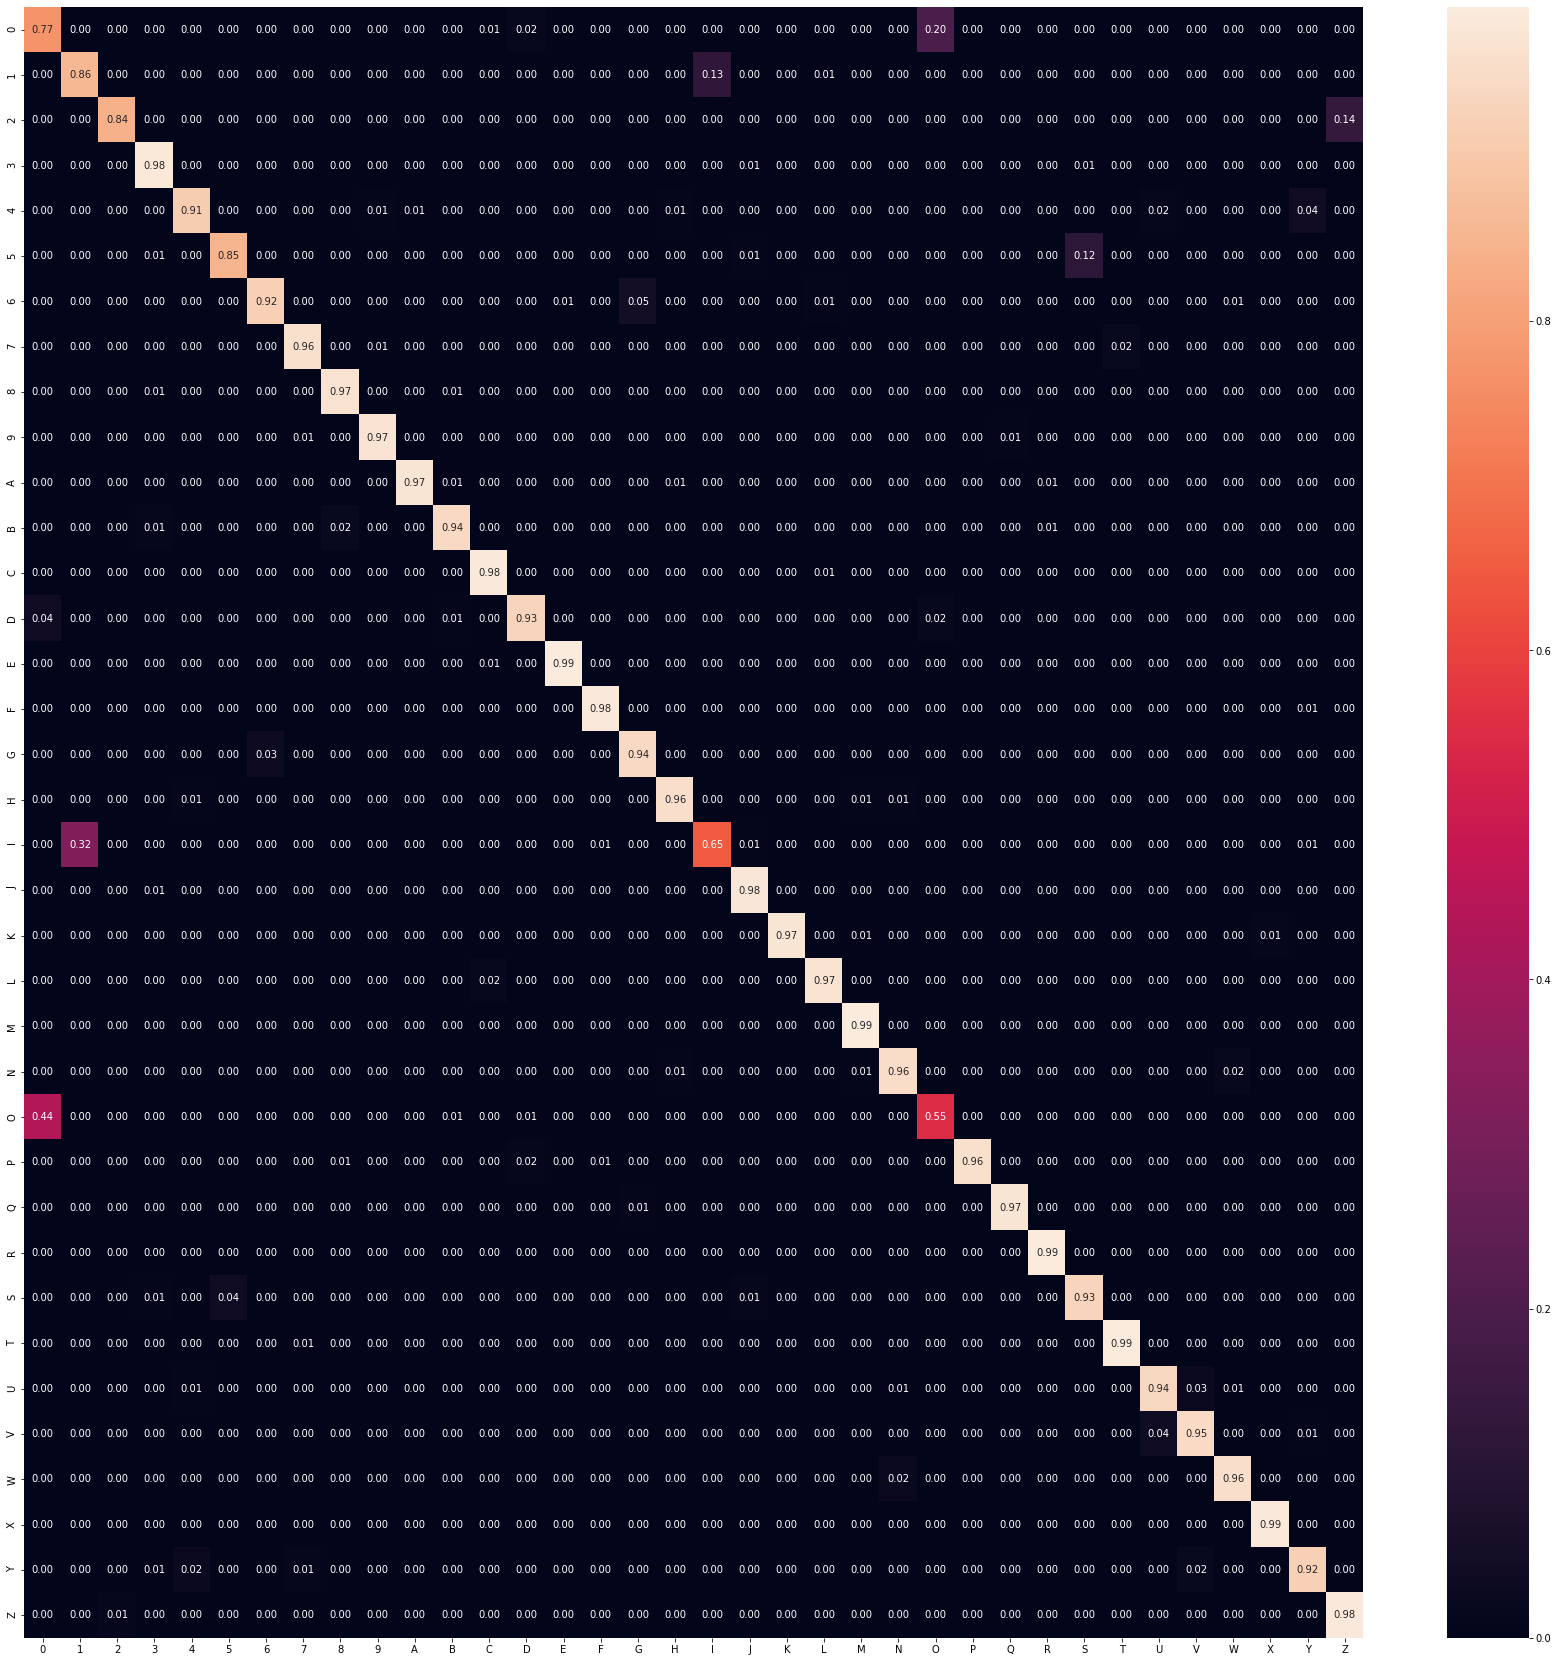

(5, 36)


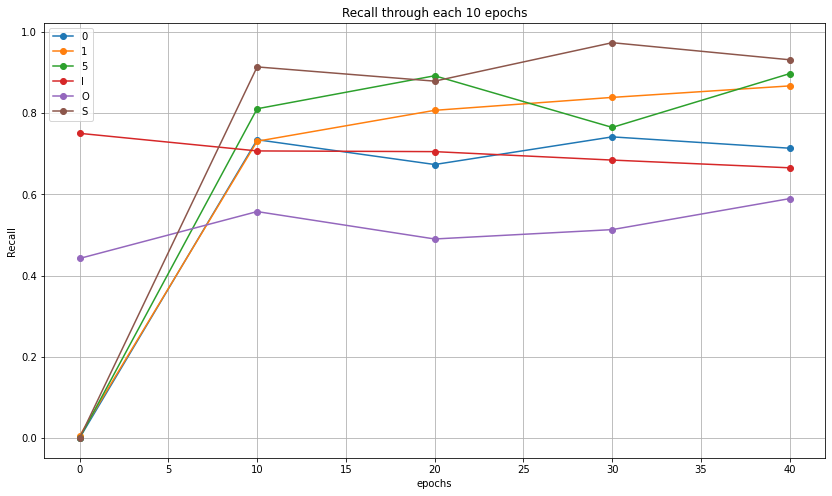

(5, 36)


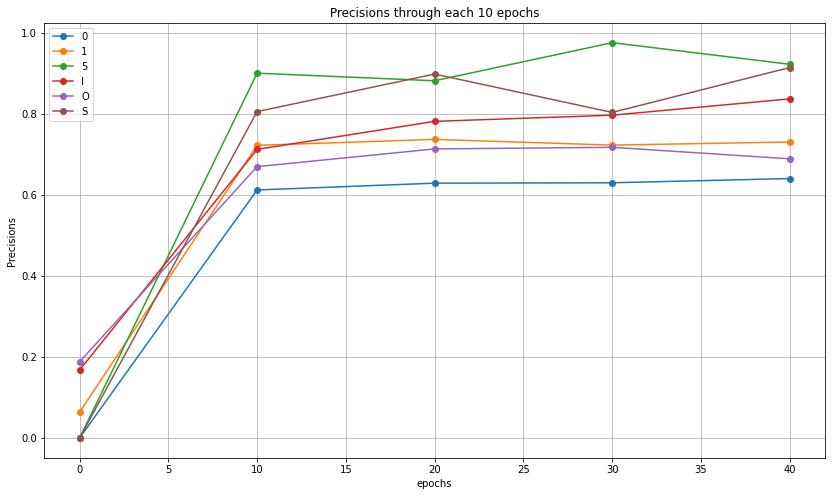

(5, 36)


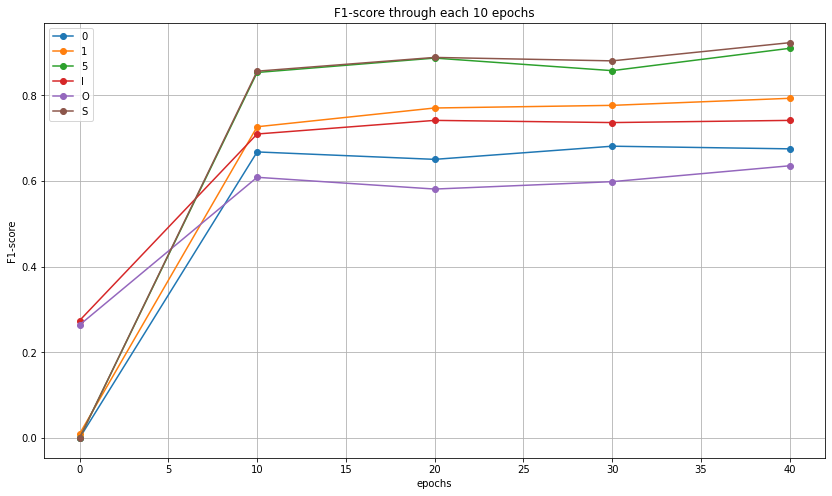

In [38]:
train_and_evaluate(myvgg2, augmentation=False)

In [39]:
def myvgg3(img_shape=(28,28,1), num_classes=36, weight_decay=1e-4):
    # Input layer
    input = Input(img_shape)
    
    # Layer 1
    x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu', bias_initializer='zeros')(input)
    x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    # Layer 2
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    
    # Layer 3
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu', bias_initializer='zeros')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
            activation='relu', bias_initializer='zeros')(x)
    
    # Layer 5
    x = Flatten()(x)
    x = Dense(units=64, activation='relu', kernel_regularizer=l2(weight_decay), bias_initializer='zeros')(x)
    x=Dropout(rate=0.3)(x)
    x = Dense(units=64, activation='relu', kernel_regularizer=l2(weight_decay), bias_initializer='zeros')(x)
    x=Dropout(rate=0.3)(x)
    
    # Output layer
    # Softmax activation
    x = Dense(units=num_classes, bias_initializer='zeros')(x)
    output=Activation('softmax')(x)

    model = Model(inputs=input, outputs=output)
    
    return model

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.20      0.88      0.33       573
           1       0.47      0.69      0.56       565
           2       0.77      0.04      0.07       544
           3       0.00      0.00      0.00       602
           4       0.22      0.27      0.24       553
           5       0.00      0.00      0.00       566
           6       1.00      0.00      0.00       583
           7       0.46      0.39      0.42       581
           8       0.10      0.05      0.07       569
           9       0.33      0.47      0.39       555
           A       0.68      0.25      0.37       540
           B       0.16      0.43      0.23       560
           C       0.71      0.12      0.21       576
           D       0.17      0.44      0.25       600
           E       0.35      0.32      0.34       612
           F       0.00      0.00      0.00       534
           G       0.25      0.24      0.25       534
           H       0.48    

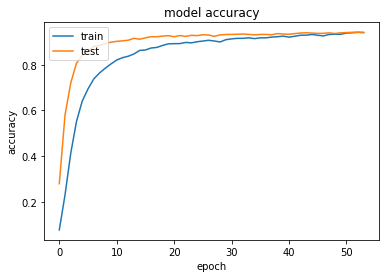

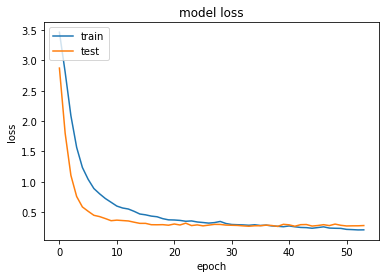

-----------------------------------------------
Final evaluation
20520/20520 [==============================] - 2s 80us/step
Accuracy on test set: [0.32551296294519777, 0.9343079924583435]
Normalized confusion matrix:
[[0.73761468 0.         0.         ... 0.         0.         0.        ]
 [0.         0.87567568 0.         ... 0.         0.         0.        ]
 [0.         0.         0.90186125 ... 0.         0.         0.08460237]
 ...
 [0.         0.         0.         ... 0.99318569 0.         0.        ]
 [0.         0.         0.         ... 0.0034662  0.91161179 0.        ]
 [0.         0.         0.02807018 ... 0.         0.         0.96842105]]


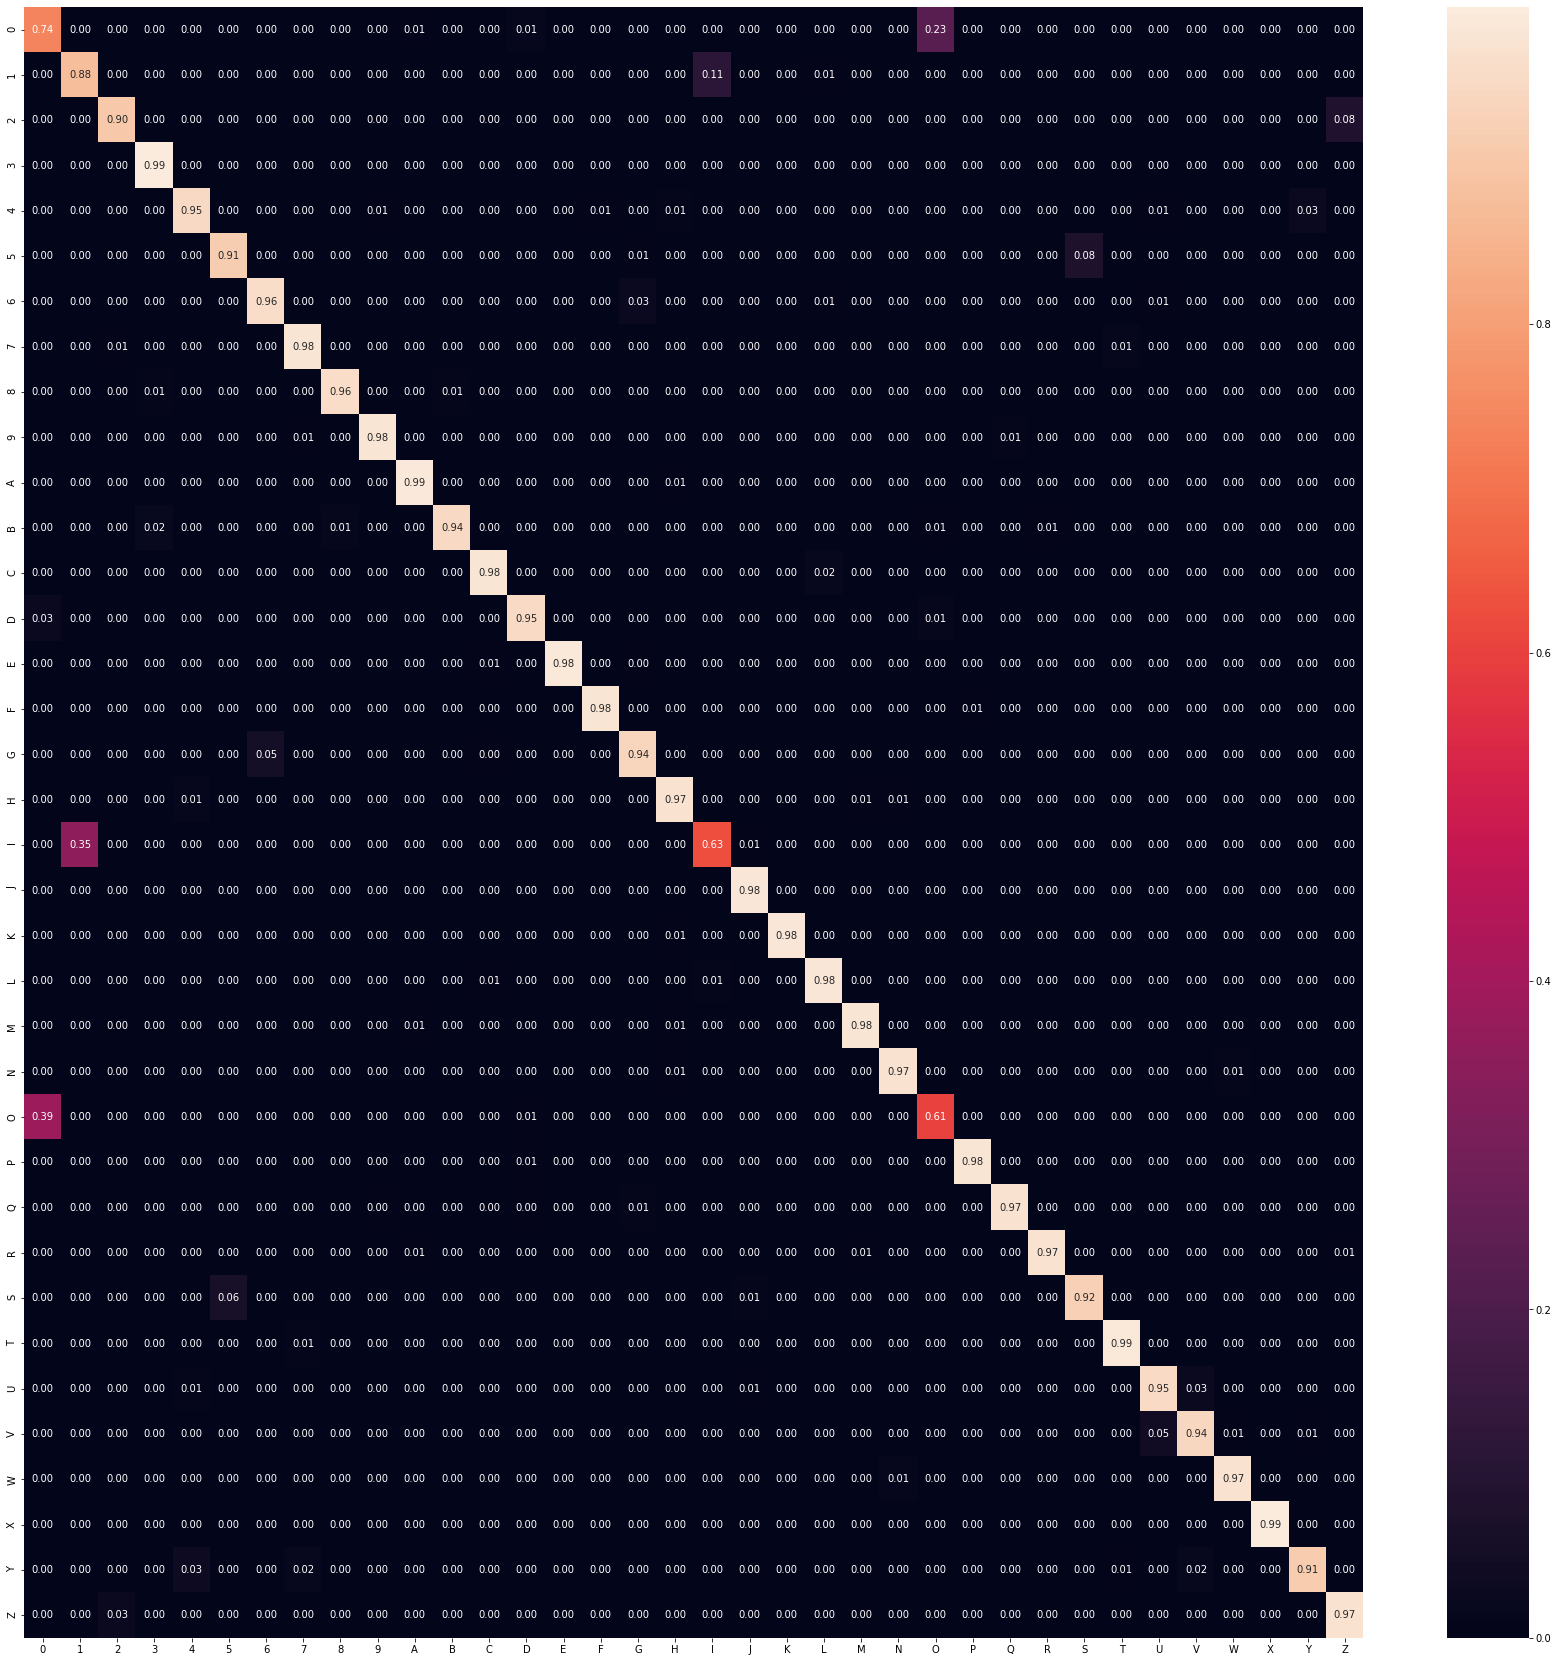

(6, 36)


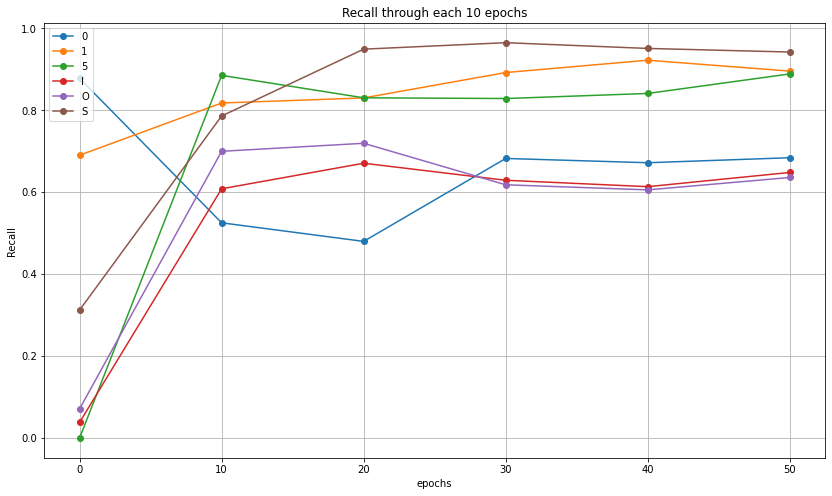

(6, 36)


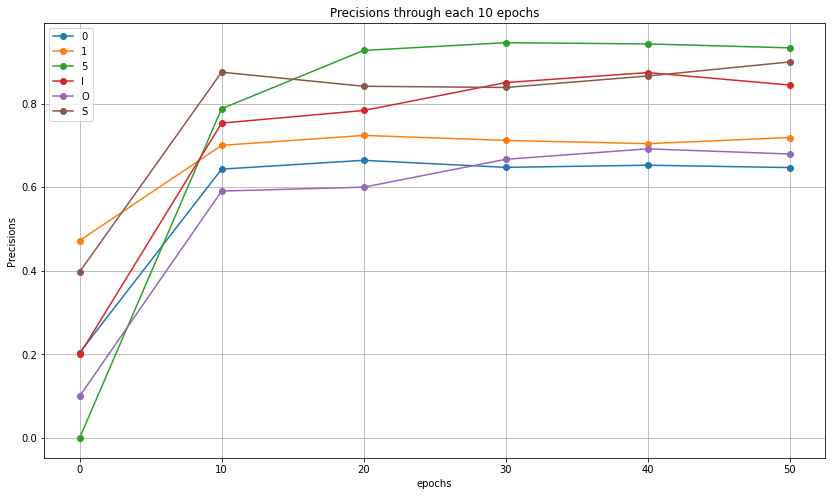

(6, 36)


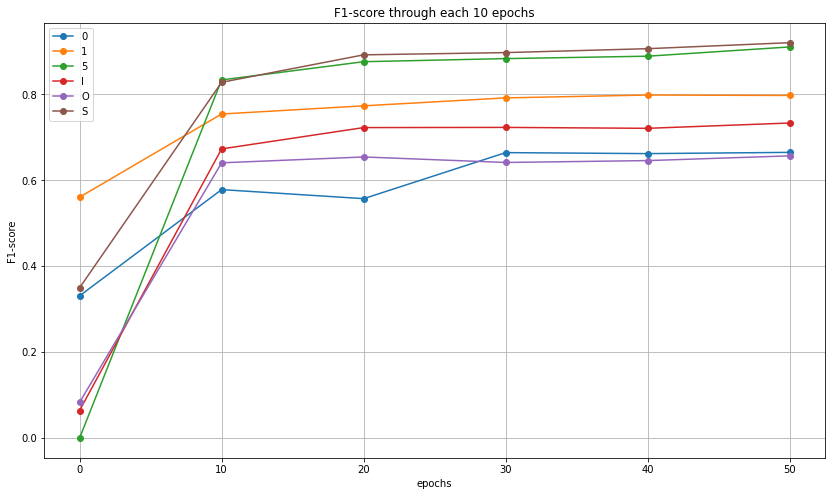

In [40]:
train_and_evaluate(myvgg3, augmentation=False)

### Custom VGG16 with data augmentation

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 64)          0   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.09      0.10      0.10       573
           1       0.31      0.77      0.44       565
           2       0.11      0.04      0.06       544
           3       0.20      0.54      0.29       602
           4       0.00      0.00      0.00       553
           5       0.00      0.00      0.00       566
           6       0.00      0.00      0.00       583
           7       0.47      0.14      0.22       581
           8       0.12      0.45      0.18       569
           9       0.20      0.36      0.26       555
           A       0.16      0.01      0.02       540
           B       0.10      0.01      0.01       560
           C       0.30      0.09      0.14       576
           D       0.40      0.06      0.10       600
           E       0.55      0.11      0.18       612
           F       0.03      0.01      0.01       534
           G       0.30      0.22      0.25       534
           H       0.15    

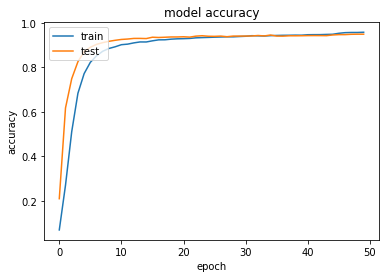

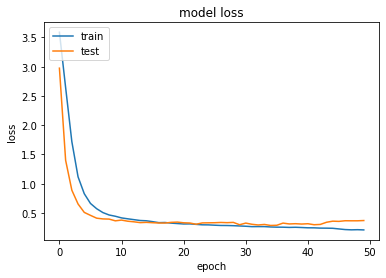

-----------------------------------------------
Final evaluation
20520/20520 [==============================] - 2s 117us/step
Accuracy on test set: [0.3581508532166481, 0.9429824352264404]
Normalized confusion matrix:
[[0.81651376 0.         0.         ... 0.         0.         0.        ]
 [0.         0.91891892 0.         ... 0.         0.0018018  0.        ]
 [0.         0.00169205 0.92554992 ... 0.         0.         0.0642978 ]
 ...
 [0.         0.         0.         ... 0.99659284 0.         0.        ]
 [0.         0.0017331  0.         ... 0.0034662  0.94107452 0.        ]
 [0.         0.         0.03157895 ... 0.         0.         0.96315789]]


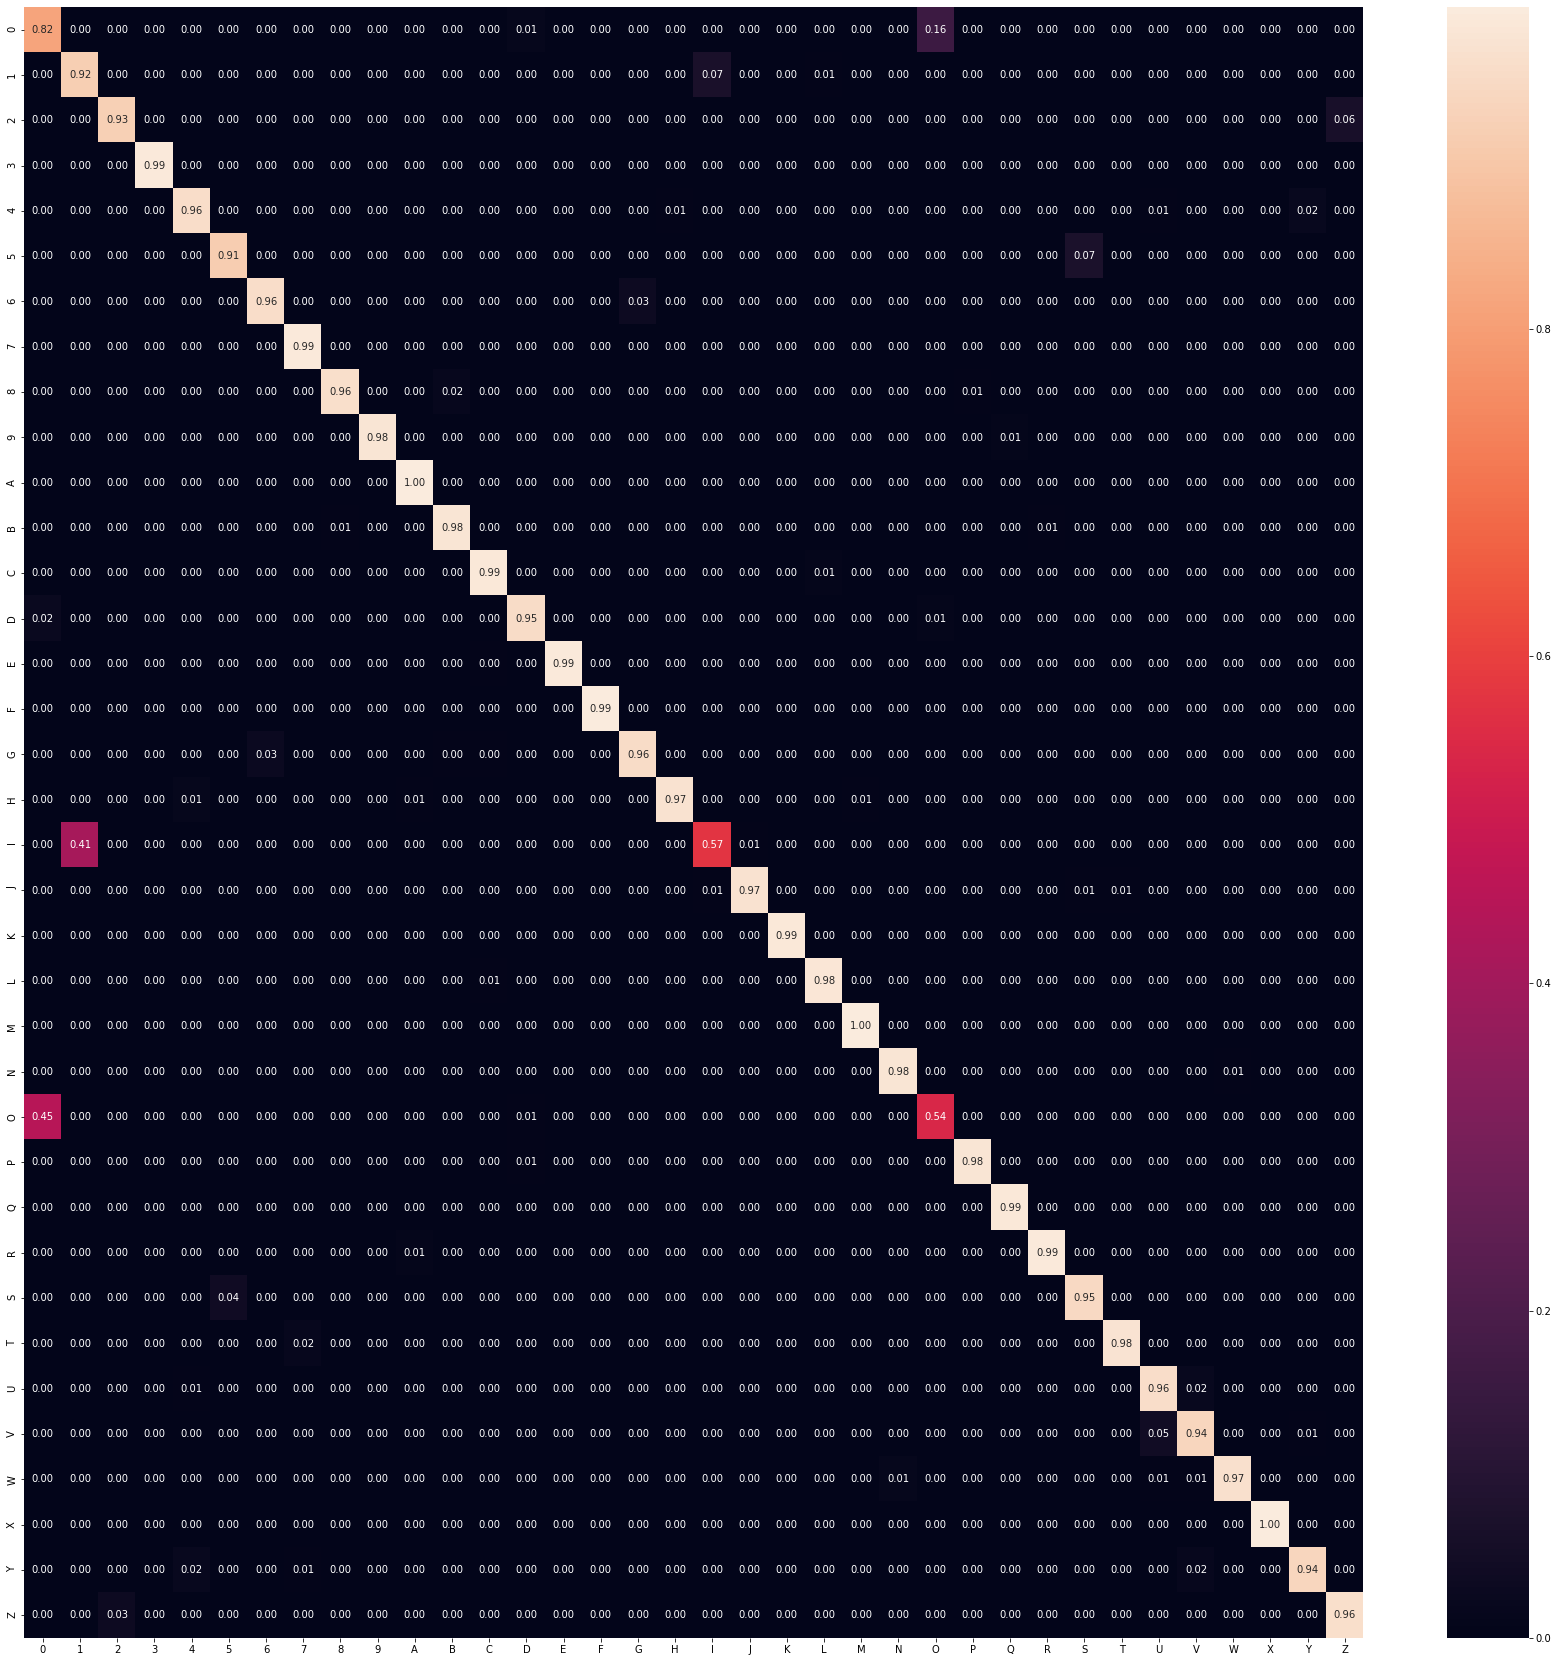

(5, 36)


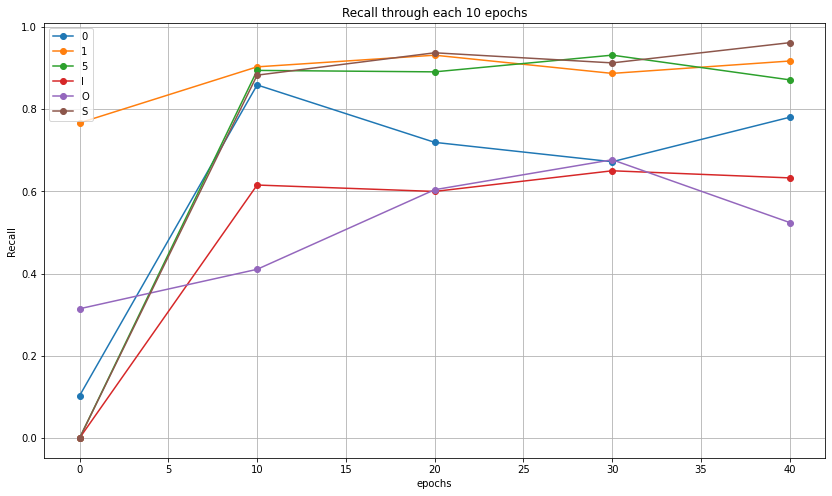

(5, 36)


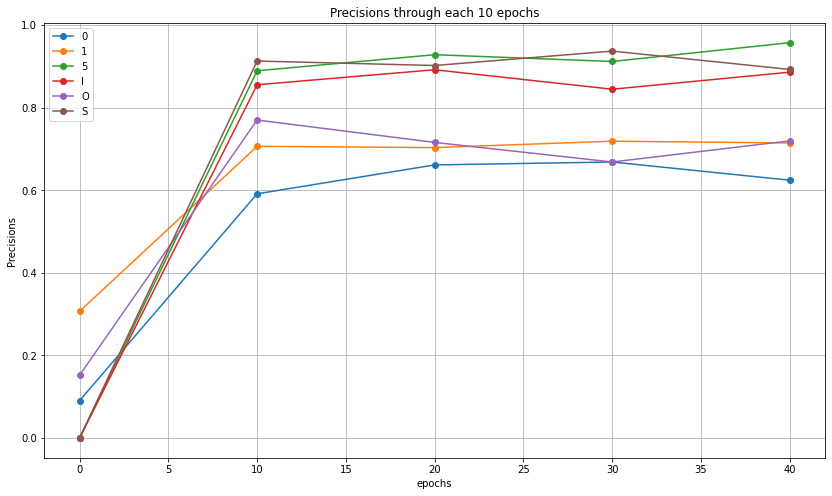

(5, 36)


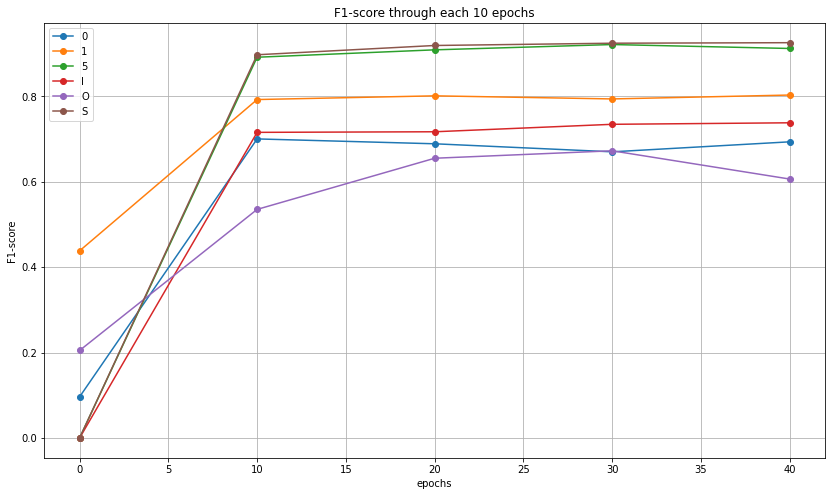

In [41]:
train_and_evaluate(myvgg, augmentation=True)

### Custom VGG16 with class weights

{0: 10, 1: 10, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 10, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 10, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1}
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 64)        18496     
__________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       573
           1       0.03      1.00      0.05       565
           2       0.00      0.00      0.00       544
           3       0.00      0.00      0.00       602
           4       0.00      0.00      0.00       553
           5       0.00      0.00      0.00       566
           6       0.00      0.00      0.00       583
           7       0.00      0.00      0.00       581
           8       0.00      0.00      0.00       569
           9       0.00      0.00      0.00       555
           A       0.00      0.00      0.00       540
           B       0.00      0.00      0.00       560
           C       0.00      0.00      0.00       576
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       612
           F       0.00      0.00      0.00       534
           G       0.00      0.00      0.00       534
           H       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       573
           1       0.54      0.97      0.70       565
           2       0.00      0.00      0.00       544
           3       0.00      0.00      0.00       602
           4       0.20      0.18      0.19       553
           5       0.31      0.33      0.32       566
           6       0.38      0.07      0.12       583
           7       0.76      0.53      0.63       581
           8       0.11      0.00      0.01       569
           9       0.04      0.01      0.01       555
           A       0.25      0.31      0.28       540
           B       0.03      0.00      0.01       560
           C       0.44      0.04      0.07       576
           D       0.00      0.00      0.00       600
           E       0.15      0.37      0.21       612
           F       0.15      0.35      0.21       534
           G       0.14      0.16      0.15       534
           H       0.26    

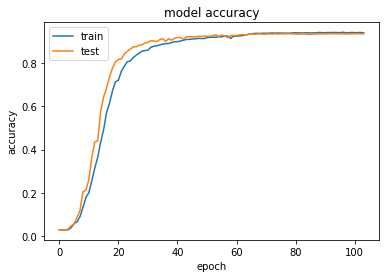

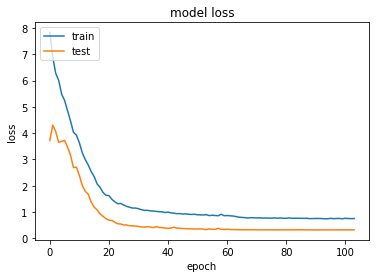

-----------------------------------------------
Final evaluation
20520/20520 [==============================] - 2s 119us/step
Accuracy on test set: [0.34083942060175465, 0.9361110925674438]
Normalized confusion matrix:
[[0.75412844 0.         0.         ... 0.         0.         0.        ]
 [0.         0.83243243 0.         ... 0.         0.         0.        ]
 [0.         0.         0.9035533  ... 0.         0.         0.08460237]
 ...
 [0.         0.         0.         ... 0.98637138 0.00340716 0.        ]
 [0.         0.         0.         ... 0.00519931 0.9220104  0.        ]
 [0.         0.         0.02280702 ... 0.         0.         0.97192982]]


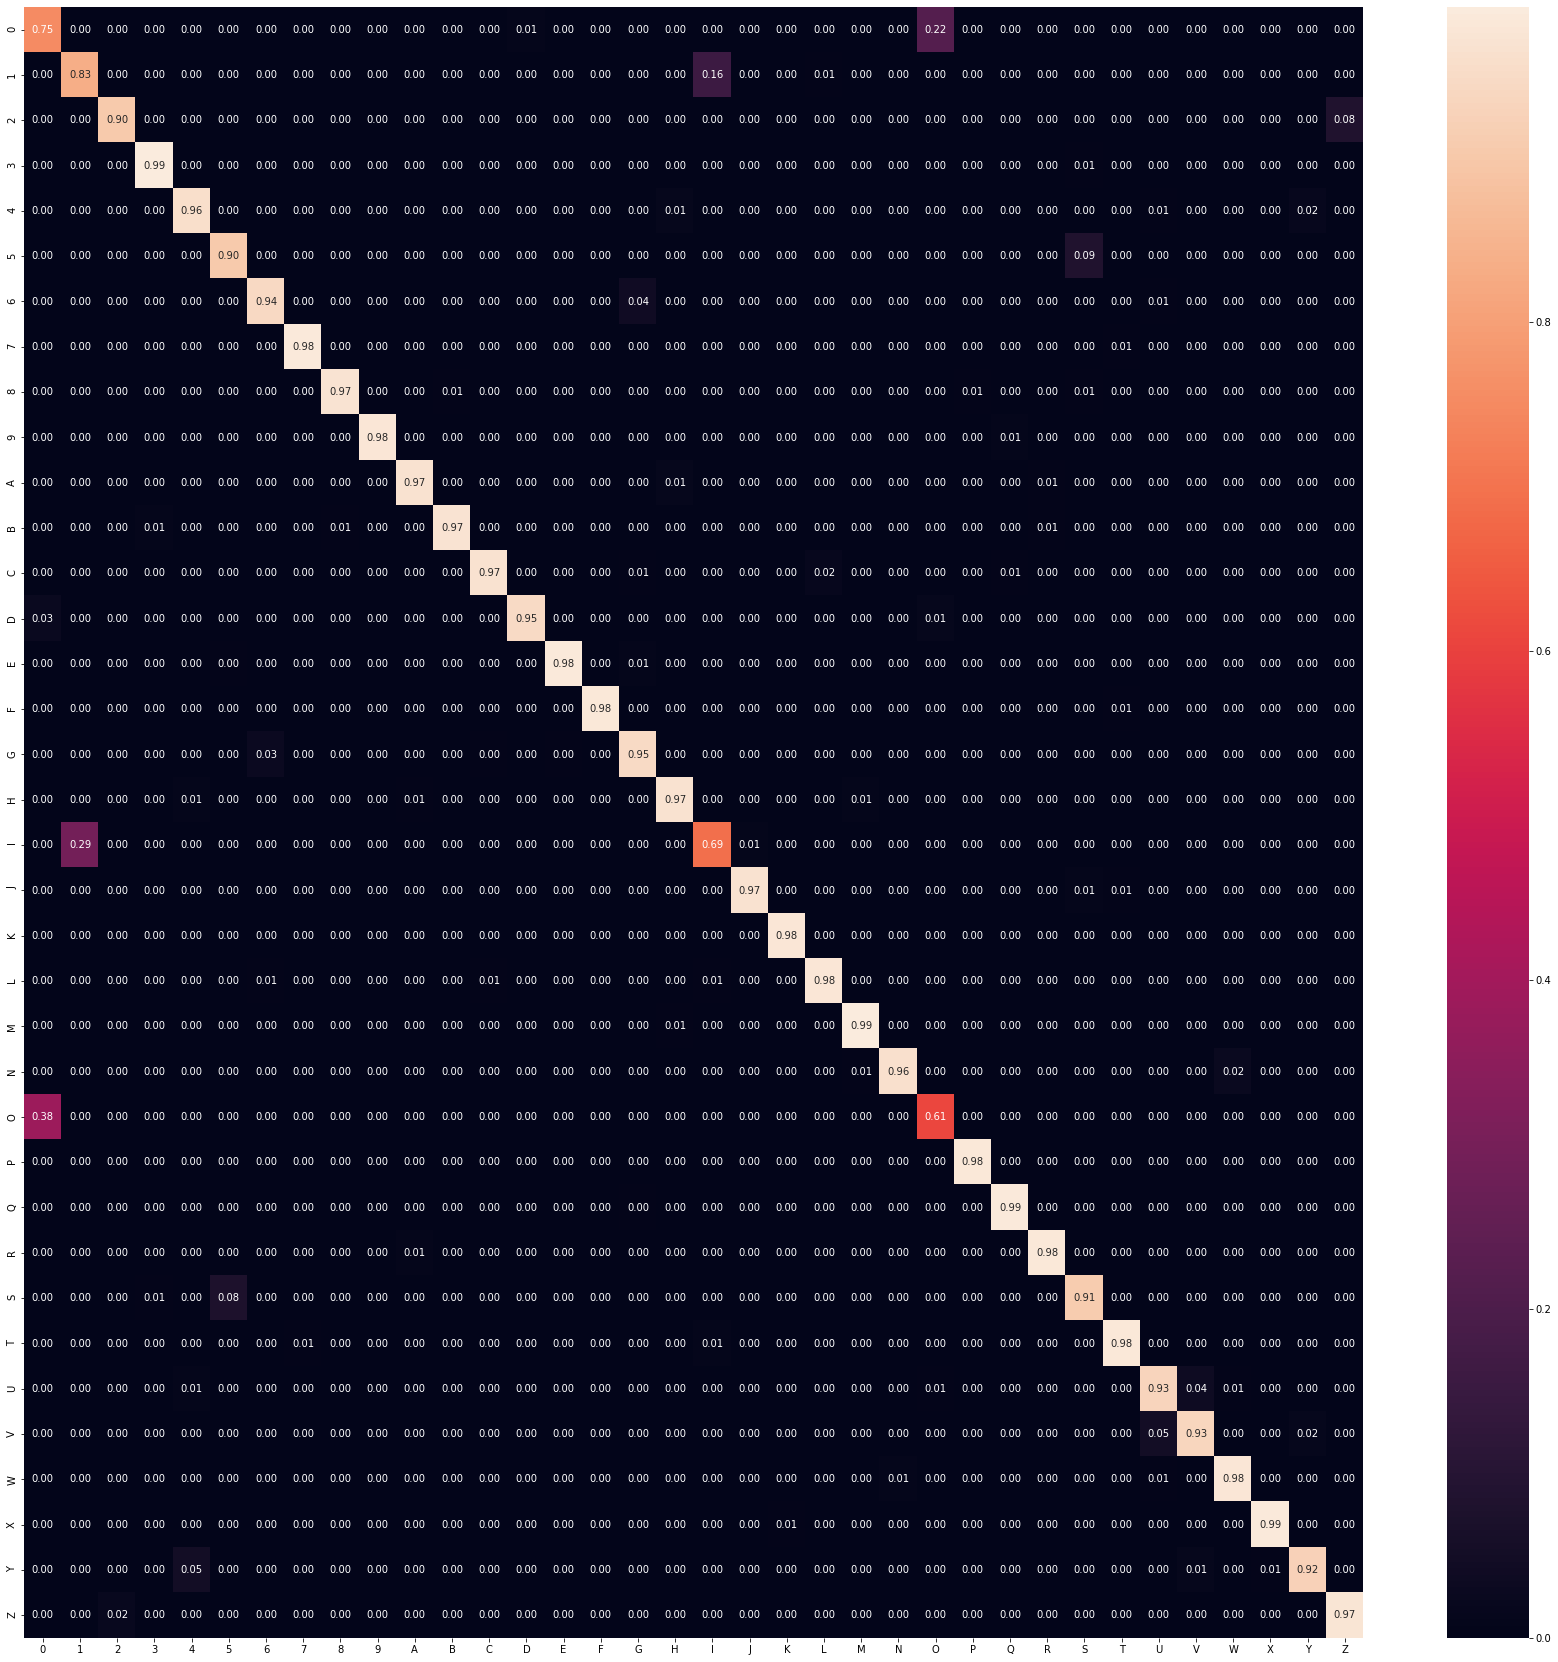

(11, 36)


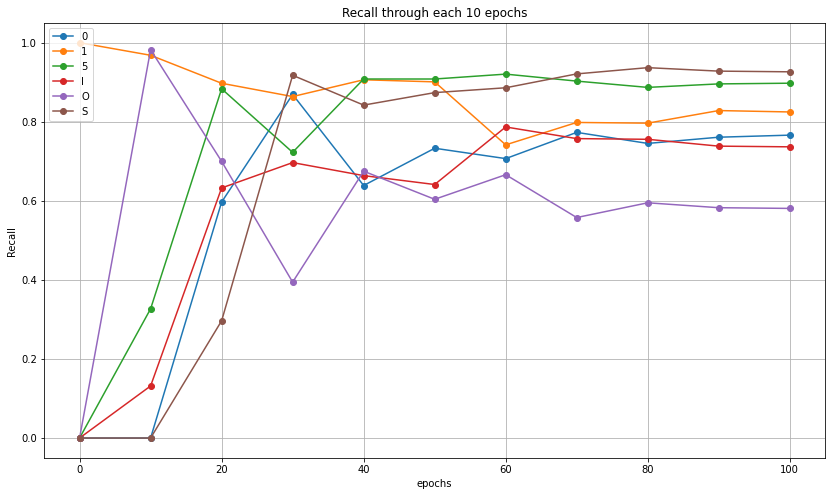

(11, 36)


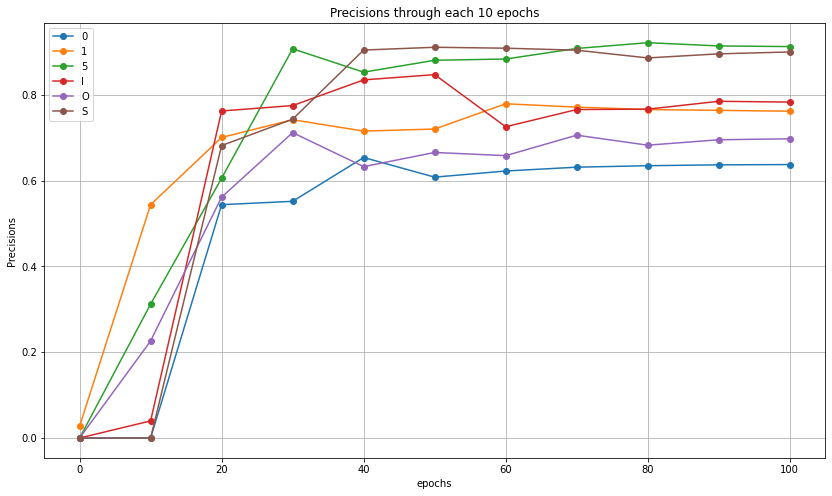

(11, 36)


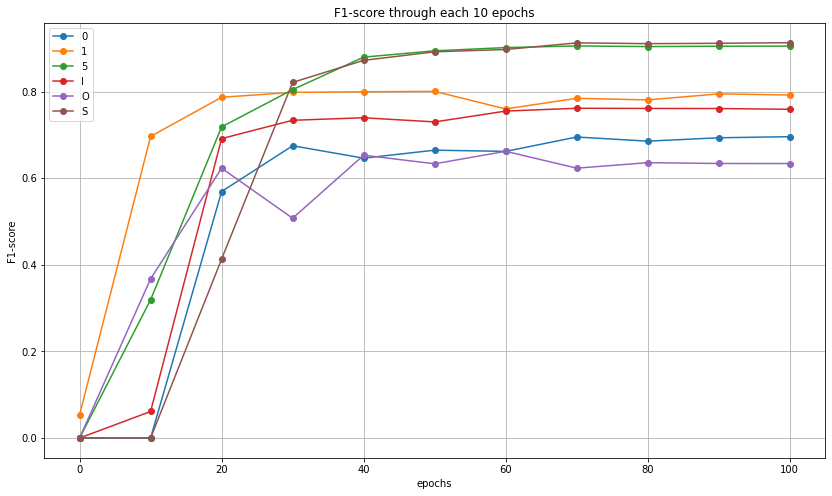

In [42]:
focus=['0', '1', 'I', 'O']
focus_idxs=[onehot_encoder.categories_[0].tolist().index(x) for x in focus]
class_weight={i:1 for i in range(36)}
for idx in focus_idxs:
    class_weight[idx]=10
print(class_weight)
train_and_evaluate(myvgg, augmentation=True, class_weight= class_weight)